## Ames Housing Prediction Code

### Introduction
In this project, we look are looking to build a predictive model for predicting the sale price of houses based on a variety of categorical and numerical features.

The dataset we are working with is the Ames Housing Dataset. Ames is a city in Story County Iowa. It is best known as the home of Iowa State University. Ames also has a population of approximately 66,258 with almost half being students of the university. [Source](https://en.wikipedia.org/wiki/Ames,_Iowa)

The original data (obtained directly from the Ames Assessor’s Office) is used for tax assessment purposes but lends itself directly to the prediction of home selling prices. The type of information contained in the data is similar to what a typical home buyer would want to know before making a purchase and students should find most variables straightforward and understandable.

We have 2 seperate datasets:
* Train data: A dataset with house characteristics and SalePrice
* Test data: This is similar to the train dataset with the exception of SalePrice

### Problem Statement

Our goal will be to find out if we can use linear regression models to accurately predict house prices on a chosen set of variables. Thereafter, we explore the results and find out which model serves us best and what the results of the model mean for predicting housing prices. We will be using root mean squared error to evaluate our models and choose the best one.

### Outline

* [Section 1: Groundwork](#sec_1)
    * 1.1 Importing Libraries
    * 1.2 Reading in Data
    * 1.3 First Look at Predicted Variable
* [Section 2: Primary Variable Selection](#sec_2)
    * 2.1 Understanding Our Data
    * 2.2 Selecting Variables to Drop
* [Section 3: Handling Irregular Data](#sec_3)
    * 3.1 Handling NaN Values
    * 3.2 Handling Outliers
* [Section 4: Identifying Potential Interaction Variables](#sec_4)
* [Section 5: Feature Engineering (Numeric Variables)](#sec_5)
    * 5.1 Adding Numeric Variables
    * 5.2 Dropping Variables
* [Section 6: Secondary Variable Selection (Numeric Variables)](#sec_6)
* [Section 7: Feature Engineering (Categorical Variables)](#sec_7)
    * 7.1 Dropping Categorical Features
    * 7.2 EDA on Categorical Features
    * 7.3 Feature Engineering for Categorical Features (ordinal)
    * 7.4 Feature Engineering for Categorical Features (nominal)
* [Section 8: Summary of Variables](#sec_8)
    * 8.1 Correlation Heatmap
    * 8.2 Splitting of Variables
* [Section 9: Model Fitting](#sec_9)
    * 9.1 Initial Model Fitting
    * 9.2 Fine Tuning Model
    * 9.3 Analysing Residuals
    * 9.4 Model Summary
    * 9.5 Conclusion and Findings
* [Section 10: Prediction](#sec_10)

## <a name="sec_1"></a>Section 1: Groundwork


### 1.1 Importing Libraries

In [1]:
# Import important stuff
import numpy as np
import pandas as pd
import patsy

from scipy import stats

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1.2 Reading in Data

In [2]:
# Read in datasets
train = pd.read_csv('C:/Users/gregw/Desktop/General Assembly/dsi-roughwork/materials/project_2/datasets/train.csv')
test = pd.read_csv('C:/Users/gregw/Desktop/General Assembly/dsi-roughwork/materials/project_2/datasets/test.csv')

In [3]:
# Keep original training data, make temp df for alteraions
df = train
df_test = test

In [4]:
# Let us iterate through the columns to ensure that naming is similar
list(set(df) - set(df_test))

['SalePrice']

### 1.3 First Look at y Variable
We plot out the SalePrice from the train dataset and take a first look.

In [5]:
# We define a variable for plotting a hist and box plot in case we need it in the future
def hist_box(df, col,
                    list_of_titles, 
                    list_of_xlabels,
                    list_of_ylabels, 
                    figsize):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = figsize)
    

    ax[0] = sns.distplot(df[col], ax = ax[0])
    ax[0].set_title(list_of_titles[0], fontsize = 14)
    ax[0].set_xlabel(list_of_xlabels[0], fontsize = 12)
    ax[0].set_ylabel(list_of_ylabels[0], fontsize = 12)
    

    ax[1] = sns.boxplot(df[col], ax = ax[1])
    ax[1].set_title(list_of_titles[1], fontsize = 14)
    ax[1].set_xlabel(list_of_xlabels[1], fontsize = 12)
    ax[1].set_ylabel(list_of_ylabels[1], fontsize = 12)

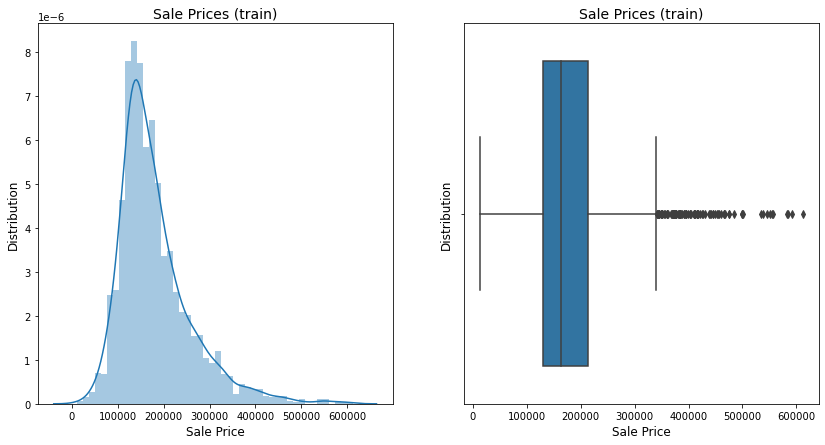

In [6]:
hist_box(df, 'SalePrice',
        ['Sale Prices (train)', 'Sale Prices (train)'],
        ['Sale Price', 'Sale Price'],
        ['Distribution',  'Distribution'],
        (14,7))

In [7]:
df['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

We see that the house sale price follows an approximately normal distribution with mean of 181,469. We see that the mass of data is concentrated between the 130,000 to 214,000 range. We see some outliers on the upper end of the scale as well.
The minimum house price is 12,982 and the maximum is 611,657. 

## <a name="sec_2"></a>Section 2: Primary Variable Selection

It is clear that there are simply too many variables in the datasets, not all of which will be useful.

The first step to the project is in dropping some variables for a start. This step should not be too absolute - we shouldn't be dropping variables that have a potential to be useful. We will drop more variables when we conduct further analysis and EDA and can see relationships visually.

### 2.1 Understanding Our Data

In [8]:
# We take a look at the shape of our data, the test data should have 1 less column
print(f"The shape of the train data is {df.shape}.")
print(f"The shape of the test data is {df_test.shape}.")

The shape of the train data is (2051, 81).
The shape of the test data is (879, 80).


In [9]:
# See extensive list of variables we have
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

We understand each variable and then choose some to drop. 

### 2.2 Selecting Variables to Drop
We will be dropping columns with the following characteristics:

1. Majority of the same values, we will use 90% as our threshold.
2. Columns with little significance in predicting sales price.
3. Columns with majority NaN values, we will use 95% as our threshold.

For a start, upon inspection, PID is not useful as there are other variables that can be used to represent housing area. There are also too many different categories for us to make sense of.
Lot Frontage, Street, Roof Style, Roof Matl, Bsmt Exposure are not useful also as they do not have any logical link to SalePrice.
We start to create a list of variables we want to drop based on our study above. We will further add to this list later on before finally dropping some columns.


In [10]:
list_to_drop = ['Lot Frontage', 'Street',  
                'Roof Style', 'Roof Matl', 'Bsmt Exposure']

In [11]:
# We create a funciton that lets us iterate through the list and returns the value counts of both the
# train and test data set
def value_counts(df_list, col):

    print("Column: %10s " % col)
    for i in range(len(df_list)):
        print("%20s" % ("Dataframe "+str(i)), end=" ")
    print("\n")

    for val in df_list[0][col].value_counts().index:
        i = 0
        for df in df_list:
            if i == len(df_list) - 1:
                print("%10s %10s" % (val, df[df[col]==val][col].count()))
            else:
                print("%10s %10s" % (val, df[df[col]==val][col].count()), end =" ")                    
            i += 1
    print("\n")

Upon some inspection, we see that Kitchen AbvGr, Heating, Central Air, Electrical and Paved Drive have majority same values. Let's use the function to inspect.

In [12]:
list_1 = ['Kitchen AbvGr',
               'Heating', 'Central Air', 'Electrical', 'Paved Drive']

for _ in list_1:
    value_counts([df, df_test], _)

Column: Kitchen AbvGr 
         Dataframe 0          Dataframe 1 

         1       1960          1        836
         2         88          2         41
         0          2          0          1
         3          1          3          1


Column:    Heating 
         Dataframe 0          Dataframe 1 

      GasA       2018       GasA        867
      GasW         20       GasW          7
      Wall          6       Wall          0
      Grav          5       Grav          4
      OthW          2       OthW          0


Column: Central Air 
         Dataframe 0          Dataframe 1 

         Y       1910          Y        824
         N        141          N         55


Column: Electrical 
         Dataframe 0          Dataframe 1 

     SBrkr       1868      SBrkr        814
     FuseA        140      FuseA         48
     FuseF         35      FuseF         15
     FuseP          7      FuseP          1
       Mix          1        Mix          0


Column: Paved Drive 
       


For Kitchen AbvGr, Heating, Central Air, Electrical and Paved Drive are not useful as there are too many similar values.

In [13]:
# We update our list
list_to_drop = ['PID', 'Lot Frontage', 'Street',  
                'Roof Style', 'Roof Matl', 'Bsmt Exposure', 
               'Kitchen AbvGr',
               'Heating', 'Central Air', 'Electrical', 'Paved Drive']

We then run a check for NaN values for purposes of dropping columns. Should there be a handful of NaNs in a specific column, we will handle them more carefully later on. 

In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [15]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               879 non-null    int64  
 1   PID              879 non-null    int64  
 2   MS SubClass      879 non-null    int64  
 3   MS Zoning        879 non-null    object 
 4   Lot Frontage     719 non-null    float64
 5   Lot Area         879 non-null    int64  
 6   Street           879 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        879 non-null    object 
 9   Land Contour     879 non-null    object 
 10  Utilities        879 non-null    object 
 11  Lot Config       879 non-null    object 
 12  Land Slope       879 non-null    object 
 13  Neighborhood     879 non-null    object 
 14  Condition 1      879 non-null    object 
 15  Condition 2      879 non-null    object 
 16  Bldg Type        879 non-null    object 
 17  House Style     

We can see that Alley, Pool QC, Fence, Misc Feature have many null values in both data sets. We will drop these columns. There are also columns related to some of these:

1. Pool Area with Pool QC - Since many pool QCs are NaNs, if pool area consists mostly of zeroes, we can drop this. 
2. Misc Val with Misc Feature. If Misc Val contains many zeroes, we can drop this.

We will look into these further.

In [16]:
list_2 = ['Alley', 'Pool QC', 'Pool Area', 'Fence', 'Misc Feature', 'Misc Val' ]

for _ in list_2:
    value_counts([df, df_test], _)

Column:      Alley 
         Dataframe 0          Dataframe 1 

      Grvl         85       Grvl         35
      Pave         55       Pave         23


Column:    Pool QC 
         Dataframe 0          Dataframe 1 

        Gd          4         Gd          0
        Fa          2         Fa          0
        TA          2         TA          1
        Ex          1         Ex          3


Column:  Pool Area 
         Dataframe 0          Dataframe 1 

         0       2042          0        875
       228          1        228          0
       368          1        368          0
       480          1        480          0
       576          1        576          0
       648          1        648          0
       738          1        738          0
       800          1        800          0
       519          1        519          0
       561          1        561          0


Column:      Fence 
         Dataframe 0          Dataframe 1 

     MnPrv        227      MnPrv  

We can thus drop Pool Area and Misc Val as well.

In [17]:
# Update list of columns to drop
list_to_drop = ['PID', 'Lot Frontage', 'Street',  
                'Roof Style', 'Roof Matl', 'Bsmt Exposure', 'Kitchen AbvGr',
               'Heating', 'Central Air', 'Electrical', 'Paved Drive',
               'Alley', 'Pool Area', 'Pool QC', 'Fence',
               'Misc Feature', 'Misc Val']

### Conduct first round dropping of columns

In [18]:
df.drop(columns = list_to_drop, inplace = True)
df_test.drop(columns = list_to_drop, inplace = True)

In [19]:
print(df.shape)
print(df_test.shape)

(2051, 64)
(879, 63)


## <a name="sec_3"></a>Section 3: Handling Irregular Data

### 3.1 Handling NaN Values
In this step, we look at replacing NaN values in certain columns.



For NaN values, we will see that they will either exist in numeric columns or categorical columns. For numeric columns, we will replace these values with 0 and for categorical columns, we will replace these with NA.

In [20]:
# We first observe the non-null values and datatypes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 64 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   MS SubClass      2051 non-null   int64  
 2   MS Zoning        2051 non-null   object 
 3   Lot Area         2051 non-null   int64  
 4   Lot Shape        2051 non-null   object 
 5   Land Contour     2051 non-null   object 
 6   Utilities        2051 non-null   object 
 7   Lot Config       2051 non-null   object 
 8   Land Slope       2051 non-null   object 
 9   Neighborhood     2051 non-null   object 
 10  Condition 1      2051 non-null   object 
 11  Condition 2      2051 non-null   object 
 12  Bldg Type        2051 non-null   object 
 13  House Style      2051 non-null   object 
 14  Overall Qual     2051 non-null   int64  
 15  Overall Cond     2051 non-null   int64  
 16  Year Built       2051 non-null   int64  
 17  Year Remod/Add

In [21]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               879 non-null    int64  
 1   MS SubClass      879 non-null    int64  
 2   MS Zoning        879 non-null    object 
 3   Lot Area         879 non-null    int64  
 4   Lot Shape        879 non-null    object 
 5   Land Contour     879 non-null    object 
 6   Utilities        879 non-null    object 
 7   Lot Config       879 non-null    object 
 8   Land Slope       879 non-null    object 
 9   Neighborhood     879 non-null    object 
 10  Condition 1      879 non-null    object 
 11  Condition 2      879 non-null    object 
 12  Bldg Type        879 non-null    object 
 13  House Style      879 non-null    object 
 14  Overall Qual     879 non-null    int64  
 15  Overall Cond     879 non-null    int64  
 16  Year Built       879 non-null    int64  
 17  Year Remod/Add  

For the both sets, we see both numeric and categorical columns that contain NaN values.

The categorical columns are 'Mas Vnr Area', 'Bsmt Cond', 'Bsmt Fin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond'. 

The numeric columns are 'Mas Vnr Type', 'BsmtFin SF 1', 'BsmtFin SF 2','Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars', 'Garage Area'.

In [22]:
# We take a closer look at these values.
list_3 = ['Mas Vnr Area', 'Bsmt Cond', 'Bsmt Qual', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 
          'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
         'Mas Vnr Type', 'BsmtFin SF 1', 'BsmtFin SF 2','Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 
          'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars', 'Garage Area']

df[list_3].isnull().sum()

Mas Vnr Area        22
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
BsmtFin Type 2      56
Fireplace Qu      1000
Garage Type        113
Garage Finish      114
Garage Qual        114
Garage Cond        114
Mas Vnr Type        22
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Yr Blt      114
Garage Cars          1
Garage Area          1
dtype: int64

From this we can see some inconsistencies, firstly, there seems to be a row that is causing some missing values. We see this from BsmtFin SF1,2, Garage Area etc. We find this row and study it.

In [23]:
df.loc[df['BsmtFin SF 1'].isnull()]

,Id,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice
1327,1342,20,RM,5940,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,...,TA,0,0,0,0,0,4,2008,ConLD,79000


In [24]:
df.loc[df['BsmtFin SF 1'].isnull()].values

array([[1342, 20, 'RM', 5940, 'IR1', 'Lvl', 'AllPub', 'FR3', 'Gtl',
        'BrkSide', 'Feedr', 'Norm', '1Fam', '1Story', 4, 7, 1946, 1950,
        'MetalSd', 'CBlock', 'None', 0.0, 'TA', 'TA', 'PConc', nan, nan,
        nan, nan, nan, nan, nan, nan, 'TA', 896, 0, 0, 896, nan, nan, 1,
        0, 2, 'TA', 4, 'Typ', 0, nan, 'Detchd', 1946.0, 'Unf', 1.0,
        280.0, 'TA', 'TA', 0, 0, 0, 0, 0, 4, 2008, 'ConLD', 79000]],
      dtype=object)

In [25]:
# We drop this row due to many nans
df = df.drop(index = 1327)

In [26]:
# We check for nulls again
df[list_3].isnull().sum()

Mas Vnr Area       22
Bsmt Cond          54
Bsmt Qual          54
BsmtFin Type 1     54
BsmtFin Type 2     55
Fireplace Qu      999
Garage Type       113
Garage Finish     114
Garage Qual       114
Garage Cond       114
Mas Vnr Type       22
BsmtFin SF 1        0
BsmtFin SF 2        0
Bsmt Unf SF         0
Total Bsmt SF       0
Bsmt Full Bath      1
Bsmt Half Bath      1
Garage Yr Blt     114
Garage Cars         1
Garage Area         1
dtype: int64

In [27]:
# We now look at the baths
df.loc[df['Bsmt Full Bath'].isnull()]

,Id,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice
616,1498,20,RL,47007,IR1,Lvl,AllPub,Inside,Gtl,Edwards,...,TA,0,372,0,0,0,7,2008,WD,284700


In [28]:
df.loc[df['Bsmt Full Bath'].isnull()].values

array([[1498, 20, 'RL', 47007, 'IR1', 'Lvl', 'AllPub', 'Inside', 'Gtl',
        'Edwards', 'Norm', 'Norm', '1Fam', '1Story', 5, 7, 1959, 1996,
        'Plywood', 'Plywood', 'None', 0.0, 'TA', 'TA', 'Slab', nan, nan,
        nan, 0.0, nan, 0.0, 0.0, 0.0, 'TA', 3820, 0, 0, 3820, nan, nan,
        3, 1, 5, 'Ex', 11, 'Typ', 2, 'Gd', 'Attchd', 1959.0, 'Unf', 2.0,
        624.0, 'TA', 'TA', 0, 372, 0, 0, 0, 7, 2008, 'WD ', 284700]],
      dtype=object)

In [29]:
# We drop this row due to many nans
df = df.drop(index = 616)

In [30]:
df[list_3].isnull().sum()

Mas Vnr Area       22
Bsmt Cond          53
Bsmt Qual          53
BsmtFin Type 1     53
BsmtFin Type 2     54
Fireplace Qu      999
Garage Type       113
Garage Finish     114
Garage Qual       114
Garage Cond       114
Mas Vnr Type       22
BsmtFin SF 1        0
BsmtFin SF 2        0
Bsmt Unf SF         0
Total Bsmt SF       0
Bsmt Full Bath      0
Bsmt Half Bath      0
Garage Yr Blt     114
Garage Cars         1
Garage Area         1
dtype: int64

In [31]:
# We now look at garage cars
df.loc[df['Garage Cars'].isnull()]

,Id,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice
1712,2237,70,RM,9060,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,NaN,174,0,212,0,0,3,2007,WD,150909


In [32]:
df.loc[df['Garage Cars'].isnull()].values

array([[2237, 70, 'RM', 9060, 'Reg', 'Lvl', 'AllPub', 'Inside', 'Gtl',
        'IDOTRR', 'Norm', 'Norm', '1Fam', '2Story', 5, 6, 1923, 1999,
        'Wd Sdng', 'Plywood', 'None', 0.0, 'TA', 'TA', 'BrkTil', 'Gd',
        'TA', 'ALQ', 548.0, 'Unf', 0.0, 311.0, 859.0, 'Ex', 942, 886, 0,
        1828, 0.0, 0.0, 2, 0, 3, 'Gd', 6, 'Typ', 0, nan, 'Detchd', nan,
        nan, nan, nan, nan, nan, 174, 0, 212, 0, 0, 3, 2007, 'WD ',
        150909]], dtype=object)

In [33]:
# We drop this row due to many nans
df = df.drop(index = 1712)

In [34]:
df[list_3].isnull().sum()

Mas Vnr Area       22
Bsmt Cond          53
Bsmt Qual          53
BsmtFin Type 1     53
BsmtFin Type 2     54
Fireplace Qu      998
Garage Type       113
Garage Finish     113
Garage Qual       113
Garage Cond       113
Mas Vnr Type       22
BsmtFin SF 1        0
BsmtFin SF 2        0
Bsmt Unf SF         0
Total Bsmt SF       0
Bsmt Full Bath      0
Bsmt Half Bath      0
Garage Yr Blt     113
Garage Cars         0
Garage Area         0
dtype: int64

Now we have a shorter list of columns with nans to deal with, let's list it below for reference.

In [35]:
list_4 = ['Mas Vnr Area', 'Bsmt Cond', 'Bsmt Qual' 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 
          'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
         'Mas Vnr Type', 'Garage Yr Blt']

In [36]:
# Let's look at 'Mas Vnr Area' and type
df.loc[df['Mas Vnr Area'].isnull()]['Mas Vnr Type']

22      NaN
41      NaN
86      NaN
212     NaN
276     NaN
338     NaN
431     NaN
451     NaN
591     NaN
844     NaN
913     NaN
939     NaN
1025    NaN
1244    NaN
1306    NaN
1430    NaN
1434    NaN
1606    NaN
1699    NaN
1815    NaN
1820    NaN
1941    NaN
Name: Mas Vnr Type, dtype: object

We set the area to 0 and type to none.

In [37]:
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None')

We move on to the columns Bsmt Cond, Qual, BsmtFin Type 1 and 2. We first check to see if these rows have basements.

In [38]:
df.loc[df['Bsmt Cond'].isnull()]['Total Bsmt SF'].sum()

0.0

In [39]:
df.loc[df['Bsmt Qual'].isnull()]['Total Bsmt SF'].sum()

0.0

In [40]:
df.loc[df['BsmtFin Type 1'].isnull()]['Total Bsmt SF'].sum()

0.0

In [41]:
df.loc[df['BsmtFin Type 2'].isnull()]['Total Bsmt SF']

12         0.0
93         0.0
114        0.0
146        0.0
183        0.0
240        0.0
249        0.0
256        0.0
390        0.0
437        0.0
485        0.0
499        0.0
514        0.0
580        0.0
581        0.0
635        0.0
642        0.0
696        0.0
700        0.0
737        0.0
772        0.0
790        0.0
794        0.0
924        0.0
933        0.0
954        0.0
1007       0.0
1022       0.0
1049       0.0
1089       0.0
1098       0.0
1125       0.0
1147    3206.0
1157       0.0
1211       0.0
1222       0.0
1252       0.0
1256       0.0
1270       0.0
1331       0.0
1377       0.0
1387       0.0
1428       0.0
1481       0.0
1594       0.0
1620       0.0
1681       0.0
1684       0.0
1686       0.0
1859       0.0
1875       0.0
1889       0.0
1933       0.0
2010       0.0
Name: Total Bsmt SF, dtype: float64

We see that for observations with Bsmt Cond nan and Bsmt Fin Type 1 nan, these houses have no basements. But there is an outlier for BsmtFin Type 2. We expand the row and locate this observation (index 1147). For simplicity, we will equate this value to BsmtFin Type 1.

In [42]:
# We habdle Bsmt Cond and Bsmt Type1 first
df['Bsmt Cond'] = df['Bsmt Cond'].fillna('NA')
df['Bsmt Qual'] = df['Bsmt Cond'].fillna('NA')
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].fillna('NA')

In [43]:
# We set the value for the particular cell
df['BsmtFin Type 2'][1147] = df['BsmtFin Type 1'][1147]

In [44]:
# We then replace nans for all other cells which have no basement
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].fillna('NA')

We move on to Fireplace Qu, we have 998 nans for this variable. We check to see if these observations indeed have fireplaces.

In [45]:
# We check to see if these have fireplaces
df.loc[df['Fireplace Qu'].isnull()]['Fireplaces'].sum()

0

In [46]:
# We can replace these nans with NA since there are no fireplaces
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('NA')

Lastly we look at Garage Type, Finish, Qual, Cond and Yr Blt. Once again, we check to see if these rows have garages

In [47]:
print(df.loc[df['Garage Type'].isnull()]['Garage Area'].sum())
print(df.loc[df['Garage Finish'].isnull()]['Garage Area'].sum())
print(df.loc[df['Garage Qual'].isnull()]['Garage Area'].sum())
print(df.loc[df['Garage Cond'].isnull()]['Garage Area'].sum())
print(df.loc[df['Garage Yr Blt'].isnull()]['Garage Area'].sum())

0.0
0.0
0.0
0.0
0.0


We see that these rows have no garages and we are comfortable to set these to NA. However, we are not sure what Garage Yr Blt is set to for observations with no Garages. We pick out a random row to find out.

In [48]:
df.loc[df['Garage Cond'] == 'NA']

,Id,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice


We see that there are no values here. It is the case that NA rows for garages have not been inputted. We will set the year to be 0.

In [49]:
df['Garage Type'] = df['Garage Type'].fillna('NA')
df['Garage Finish'] = df['Garage Finish'].fillna('NA')
df['Garage Qual'] = df['Garage Qual'].fillna('NA')
df['Garage Cond'] = df['Garage Cond'].fillna('NA')
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(0)


This should handle the nans for our train set, let's have a look

In [50]:
df.isnull().sum().sort_values(ascending = False)

Id                 0
MS SubClass        0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
                  ..
Bsmt Cond          0
BsmtFin Type 1     0
BsmtFin SF 1       0
BsmtFin Type 2     0
SalePrice          0
Length: 64, dtype: int64

Now we move on to look at the test set.

In [51]:
null_test = pd.DataFrame()
null_test['Nans'] = df_test.isnull().sum()

In [52]:
null_test.loc[null_test['Nans'] != 0]

,Nans
Mas Vnr Type,1
Mas Vnr Area,1
Bsmt Qual,25
Bsmt Cond,25
BsmtFin Type 1,25
BsmtFin Type 2,25
Fireplace Qu,422
Garage Type,44
Garage Yr Blt,45
Garage Finish,45


We see similar issues with the test data for basement, fireplaces and garage. We run the same checks.

In [53]:
# Start with basement
print(df_test.loc[df_test['Bsmt Cond'].isnull()]['Total Bsmt SF'].sum())
print(df_test.loc[df_test['Bsmt Cond'].isnull()]['Total Bsmt SF'].sum())
print(df_test.loc[df_test['BsmtFin Type 1'].isnull()]['Total Bsmt SF'].sum())
print(df_test.loc[df_test['BsmtFin Type 2'].isnull()]['Total Bsmt SF'].sum())

0
0
0
0


In [54]:
# We replace these values
df_test['Bsmt Cond'] = df_test['Bsmt Cond'].fillna('NA')
df_test['Bsmt Qual'] = df_test['Bsmt Cond'].fillna('NA')
df_test['BsmtFin Type 1'] = df_test['BsmtFin Type 1'].fillna('NA')
df_test['BsmtFin Type 2'] = df_test['BsmtFin Type 2'].fillna('NA')

In [55]:
# We then check fireplace Qu
df_test.loc[df_test['Fireplace Qu'].isnull()]['Fireplaces'].sum()

0

In [56]:
# We replace as well
df_test['Fireplace Qu'] = df_test['Fireplace Qu'].fillna('NA')

In [57]:
# We move on to garage
print(df_test.loc[df_test['Garage Type'].isnull()]['Garage Area'].sum())
print(df_test.loc[df_test['Garage Qual'].isnull()]['Garage Area'].sum())
print(df_test.loc[df_test['Garage Cond'].isnull()]['Garage Area'].sum())
print(df_test.loc[df_test['Garage Finish'].isnull()]['Garage Area'].sum())
print(df_test.loc[df_test['Garage Yr Blt'].isnull()]['Garage Area'].sum())

0
360
360
360
360


We see one outlier. Let's have a look at the Garage type for that observation

In [58]:
df_test.loc[df_test['Garage Qual'].isnull()]['Garage Area']

29       0
45       0
66       0
68       0
106      0
110      0
114      0
145      0
153      0
157      0
181      0
219      0
231      0
232      0
257      0
283      0
306      0
315      0
321      0
338      0
342      0
351      0
360      0
396      0
483      0
497      0
528      0
530      0
537      0
556      0
567      0
592      0
597      0
611      0
616      0
619      0
630      0
675      0
699      0
712      0
765    360
780      0
804      0
814      0
860      0
Name: Garage Area, dtype: int64

We then look at the average value counts for these columns in our test data.
We see that the outlier is at index 765, we find out the garage type for that row.

In [59]:
(df_test.loc[765, 'Garage Type' ])

'Detchd'

There is no way for us to know what the state of that garage is, we will replace the values with the most common features of the test data set. We will have to do more specific filtering for finish

In [60]:
df_test.groupby(by ='Garage Type')['Garage Finish'].value_counts()

Garage Type  Garage Finish
2Types       Unf                2
             Fin                1
             RFn                1
Attchd       RFn              209
             Fin              166
             Unf              143
Basment      Unf                6
             RFn                2
             Fin                1
BuiltIn      Fin               39
             RFn               11
             Unf                4
CarPort      Unf                4
Detchd       Unf              223
             Fin               12
             RFn               10
Name: Garage Finish, dtype: int64

In [61]:
garage_features = ['Garage Qual', 'Garage Cond', 'Garage Finish']
for _ in garage_features:
    value_counts([df, df_test], _)

Column: Garage Qual 
         Dataframe 0          Dataframe 1 

        TA       1830         TA        783
        NA        113         NA          0
        Fa         82         Fa         42
        Gd         18         Gd          6
        Ex          3         Ex          0
        Po          2         Po          3


Column: Garage Cond 
         Dataframe 0          Dataframe 1 

        TA       1866         TA        797
        NA        113         NA          0
        Fa         47         Fa         27
        Gd         12         Gd          3
        Po          8         Po          6
        Ex          2         Ex          1


Column: Garage Finish 
         Dataframe 0          Dataframe 1 

       Unf        847        Unf        382
       RFn        579        RFn        233
       Fin        509        Fin        219
        NA        113         NA          0




For that row, we will set finish to Unf, Cond to TA, Qual to TA and Yr Built to the year built of the house.

In [62]:
df_test.loc[765, 'Garage Finish'] = 'Unf'
df_test.loc[765, 'Garage Cond'] = 'TA'
df_test.loc[765, 'Garage Qual'] = 'TA'
df_test.loc[765, 'Garage Yr Blt'] = df_test.loc[765, 'Year Built']


In [63]:
# We then can replace the other rows with no garages
df_test['Garage Type'] = df_test['Garage Type'].fillna('NA')
df_test['Garage Finish'] = df_test['Garage Finish'].fillna('NA')
df_test['Garage Qual'] = df_test['Garage Qual'].fillna('NA')
df_test['Garage Cond'] = df_test['Garage Cond'].fillna('NA')
df_test['Garage Yr Blt'] = df_test['Garage Yr Blt'].fillna(0)

In [64]:
df_test.isnull().sum().sort_values(ascending = False)

Mas Vnr Area      1
Mas Vnr Type      1
Id                0
Heating QC        0
2nd Flr SF        0
                 ..
BsmtFin Type 1    0
BsmtFin SF 1      0
BsmtFin Type 2    0
BsmtFin SF 2      0
Sale Type         0
Length: 63, dtype: int64

We are left with Mas Vnr Area and Mas Vnr type, we will set these to 0 and None.

In [65]:
df_test['Mas Vnr Type'] = df_test['Mas Vnr Type'].fillna('None')
df_test['Mas Vnr Area'] = df_test['Mas Vnr Area'].fillna(0)

We now look at whether or not any nan values are left.

In [66]:
df_test.isnull().sum().sort_values(ascending = False)

Id                 0
Fireplace Qu       0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
                  ..
Bsmt Cond          0
BsmtFin Type 1     0
BsmtFin SF 1       0
BsmtFin Type 2     0
Sale Type          0
Length: 63, dtype: int64

In [67]:
# We then check the maximum null values for both datasets, if this was run correctly, it should be zero
print(df.isnull().sum().max())
print(df_test.isnull().sum().max())

0
0


### 3.2 Handling Outliers
As mentioned in the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), there are some observations that we may wish to remove from the data set (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set.

<AxesSubplot:xlabel='Gr Liv Area', ylabel='SalePrice'>

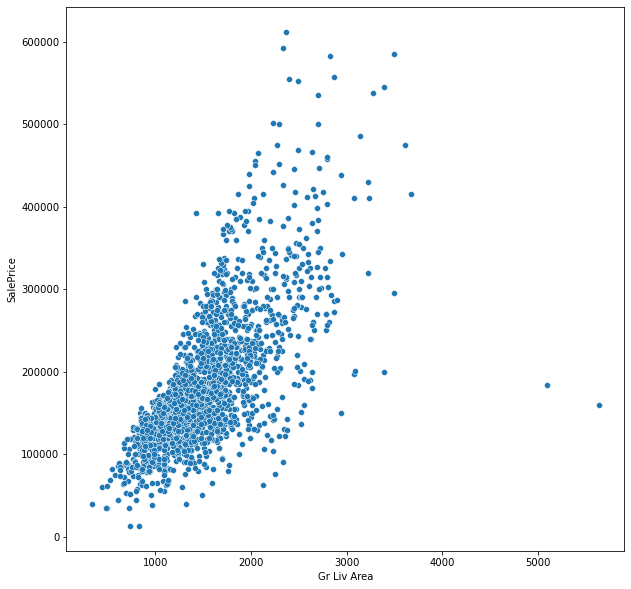

In [68]:
# We first plot a scatter plot to see where the outliers are
plt.figure(figsize = (10,10))
sns.scatterplot(x = 'Gr Liv Area', y = 'SalePrice', data = df)

We can clearly see the 2 outliers on the right of the graph where 2 large houses sold for relatively cheap prices. We should remove these rows.

In [69]:
# We filter out these rows and determine their index
df.loc[df['Gr Liv Area'] > 4000]

,Id,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,60,RL,63887,IR3,Bnk,AllPub,Corner,Gtl,Edwards,...,TA,214,292,0,0,0,1,2008,New,160000
1885,2181,20,RL,39290,IR1,Bnk,AllPub,Inside,Gtl,Edwards,...,TA,546,484,0,0,0,10,2007,New,183850


In [70]:
# We can then remove these rows
df = df.drop([960, 1885])

In [71]:
# plotting the same filter as above should return us 0 rows.
df.loc[df['Gr Liv Area'] > 4000]

,Id,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice


## <a name="sec_4"></a>Section 4: Identifying Potential Interaction Variables

As of this point, we have looked at our data, removed some variables that are not useful and also cleaned our data (replacing NaNs and removing outliers). The next step will be to identify some potential interaction terms. In regression, an [interaction effect](https://stattrek.com/multiple-regression/interaction.aspx) exists when the effect of an independent variable on a dependent variable changes, depending on the value(s) of one or more other independent variables.

Looking at the data, there are some potential pairs we can look at:

* Land Contour (cat) and Land Slope (cat)
* Overall Qual (num) and Overal Cond (num)
* Exter Qual (cat) and Exter Cond (cat)
* Garage Qual (cat) and Garage Cond (cat)

There are 4 pairs in total, 3 categorical and 1 numeric. We will keep these in mind and experiment with them in later steps.

## <a name="sec_5"></a>Section 5: Feature Engineering (Numerical Columns)

In this section, we focus on numeric columns. Our goal will be to deduce which numeric variable are meaningful for our prediction of house prices. These can either be existing columns, transformations of existing columns or new columns added based on what we have (interaction terms etc).

### 5.1 Adding Additional Variables
Let us first take a look at the correlation matrix of numerical features to have a better sensing.

<AxesSubplot:title={'center':'Correlation Matrix of Num Variabes'}>

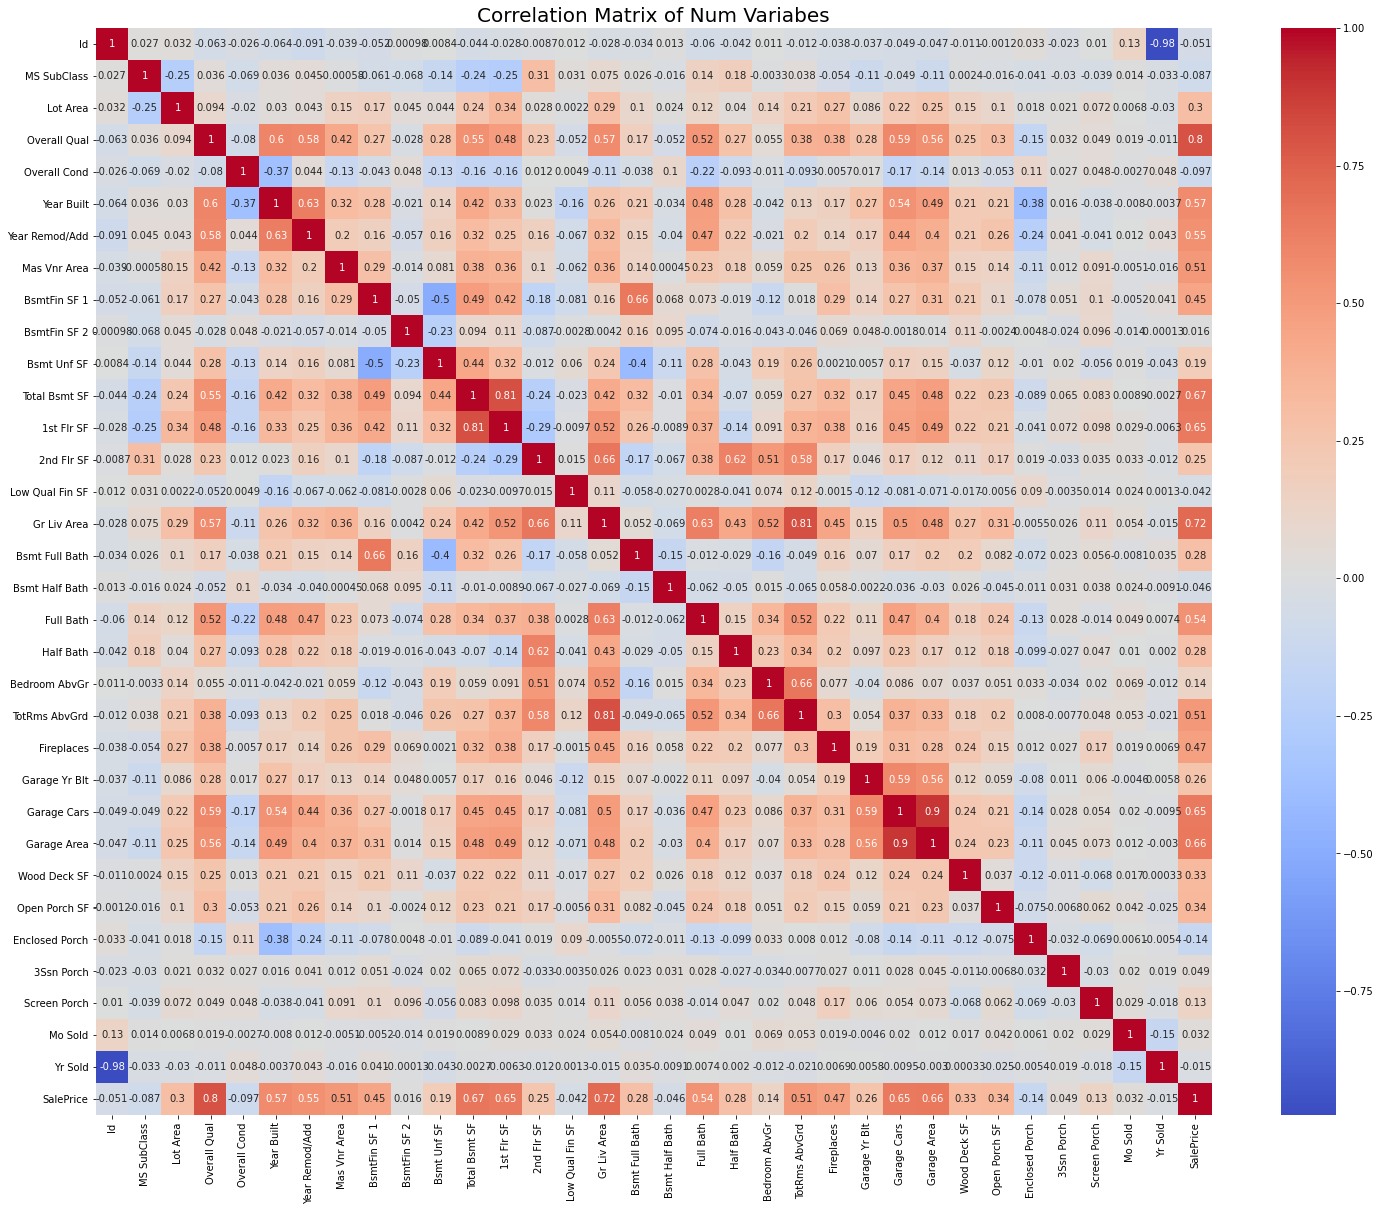

In [72]:
# We plot the correlation matrix below
plt.figure(figsize = (25,20))
plt.title('Correlation Matrix of Num Variabes', fontsize = 20)
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

We will revisit this heatmap later on after refining the variables, but for now, we are interested in finding out if we should add in any columns. First off, we start with looking to see if we should add the interaction term between Overall Cond and Overall Qual (as mentioned in section 4).

<AxesSubplot:>

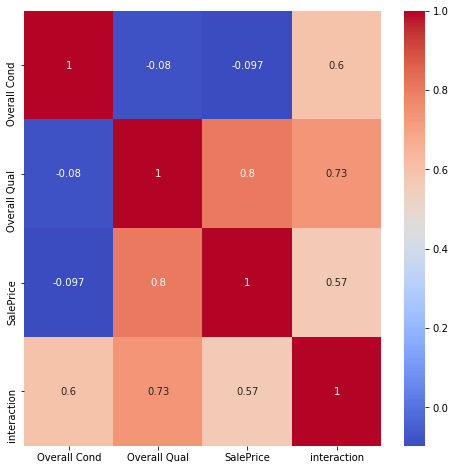

In [73]:
# We create a new dataframe to hold these 2 variables and the Saleprice for simplicity
overall_qual_cond = df[['Overall Cond', 'Overall Qual', 'SalePrice']]

# Then we add in the interaction term
overall_qual_cond['interaction'] = overall_qual_cond['Overall Cond'] * overall_qual_cond['Overall Qual']

# Then we plot out a simple heatmap for this temporary dataframe
plt.figure(figsize = (8,8))
sns.heatmap(overall_qual_cond.corr(), annot = True, cmap = 'coolwarm')

We see that the interaction term still has a lower correlation as compared to 'Overall Qual'. This does not look too helpful and we can leave it out. Overall Cond is also not useful. We can drop this variable with its correlation being so low.

Next we add in a new variable to note the age of house/ age since remodelled at the time of sale. This is so that the stagnant variables such as the year the house was built and when the house was sold make more sense. After doing so, the year built, year remod/add, year sold and month sold columns do not serve us much purpose anymore with such low correlations.

In [74]:
# We introduce 2 new variables, the first being the age of the house at sale and 
# another being the age since remod/ built.
df['House Age'] = df['Yr Sold'] - df['Year Built']
df['Remod Age'] = df['Yr Sold'] - df['Year Remod/Add']
df_test['House Age'] = df_test['Yr Sold'] - df_test['Year Built']
df_test['Remod Age'] = df_test['Yr Sold'] - df_test['Year Remod/Add']

Next we look to see if we can improve the correlation of some columns if we combine them. Our guiding principle will be seemingly irrelevant columns. 

* Deck and Porch variables have relatively low significance, we will see if we can combine these.
* Look to see if we can combine the bathroom variables to have a better variable.
* Look to see if we can combine BsmtFin SF 2 with BsmtFin SF 1 to generate a better variable.

In [75]:
# We focus on the porch and deck variables. We can change this in a couple of ways and compare.
# We create a new dataframe and input these values

porch_deck = df[['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'SalePrice']]
porch_deck['Decks'] = porch_deck['Wood Deck SF'] + porch_deck['Open Porch SF']
porch_deck['Porches'] = porch_deck['Enclosed Porch'] + porch_deck['3Ssn Porch'] + porch_deck['Screen Porch']
porch_deck['Deck and Porch'] = porch_deck['Decks'] + porch_deck['Porches']

<AxesSubplot:>

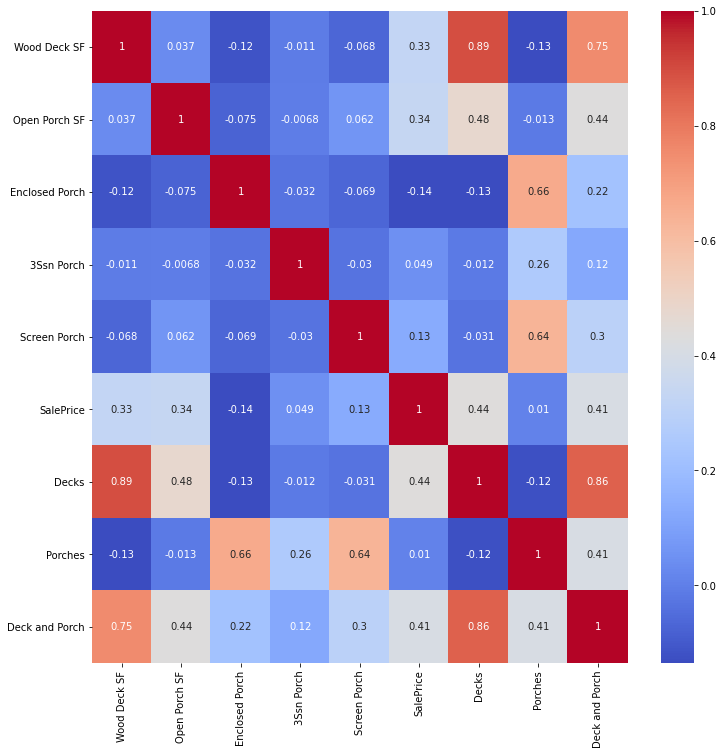

In [76]:
# We then plot a heatmap and see if correlation has improved
plt.figure(figsize = (12,12))
sns.heatmap(porch_deck.corr(), annot = True, cmap = 'coolwarm')

From the heatmap, we can see that combined decks have the highest correlation and porches have none. Combining them is also not useful. We will add in a new variable for decks and remove all 5 original variables.


In [77]:
# We add in the new column for decks
df['Decks'] = df['Wood Deck SF'] + df['Open Porch SF']
df_test['Decks'] = df_test['Wood Deck SF'] + df_test['Open Porch SF']


Next we look at the bathroom variables and perform similar steps.

In [78]:
# We look to see if we can combine the bathroom variables. we will create a few iterations, similar to porch and deck
baths = df[['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'SalePrice']]
baths['Bsmt Baths'] = baths['Bsmt Full Bath'] + (0.5 * baths['Bsmt Half Bath'])
baths['Abv Grd Baths'] = baths['Full Bath'] + (0.5 * baths['Half Bath'])
baths['Total Baths'] = baths['Bsmt Baths'] + baths['Abv Grd Baths']

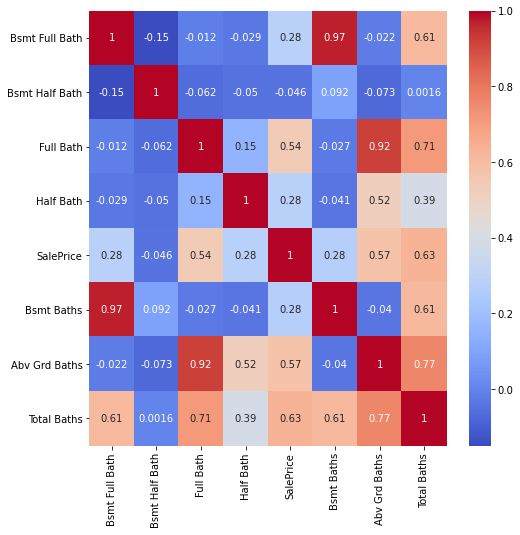

In [79]:
plt.figure(figsize = (8,8))
sns.heatmap(baths.corr(), annot = True, cmap = 'coolwarm');

From the correlaton plot above, we can conclude that combining the baths will give us a better explanatory variable. we will introduce a new variable and drop the old columns.

In [80]:
# We add in the new columns for Baths
df['Baths'] = df['Bsmt Full Bath'] + df['Full Bath'] + (0.5 * df['Bsmt Half Bath']) + (0.5 * df['Half Bath'])
df_test['Baths'] = df_test['Bsmt Full Bath'] + df_test['Full Bath'] + (0.5 * df_test['Bsmt Half Bath']) + (0.5 * df_test['Half Bath'])


Next we look at BsmtFin SF 1 and 2 and once again perform similar steps

In [81]:
# We look to see if we can combine BsmtFin SF 2 with BsmtFin SF 1 to generate a better variable
bsmtfin = df[['BsmtFin SF 1', 'BsmtFin SF 2', 'SalePrice']]
bsmtfin['BsmtFin SF'] = bsmtfin['BsmtFin SF 1'] + bsmtfin['BsmtFin SF 2']

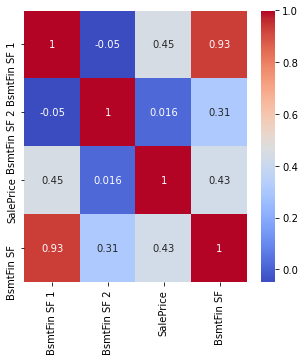

In [82]:
plt.figure(figsize = (5,5))
sns.heatmap(bsmtfin.corr(), annot = True, cmap = 'coolwarm');

We see that correlation does not improve, we can drop BsmtFin SF 2.
Before we move on to refining our variables, let's drop the variables which we do not need as part of our findings for section 5.1.

In [83]:
# We create a list of variables we want to drop.
list_to_drop_1 = ['Overall Cond', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                  'Mo Sold','Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 
                  '3Ssn Porch', 'Screen Porch','Bsmt Full Bath', 'Bsmt Half Bath', 
                  'Full Bath', 'Half Bath', 'BsmtFin SF 2' ]

In [84]:
df.drop(columns = list_to_drop_1, inplace = True)
df_test.drop(columns = list_to_drop_1, inplace = True)

### 5.2 Dropping Numeric Variables

Next we look at the correlation heatmap of our remaining numeric values and observe the matrix and see which other variables we can remove. We will be doing so and looking out for:

* Variables with a high correlation to each other (this is to eliminate multicolinearity)
* Establish any links between columns and see if either will suffice.


<AxesSubplot:title={'center':'Correlation Matrix of Num Variabes'}>

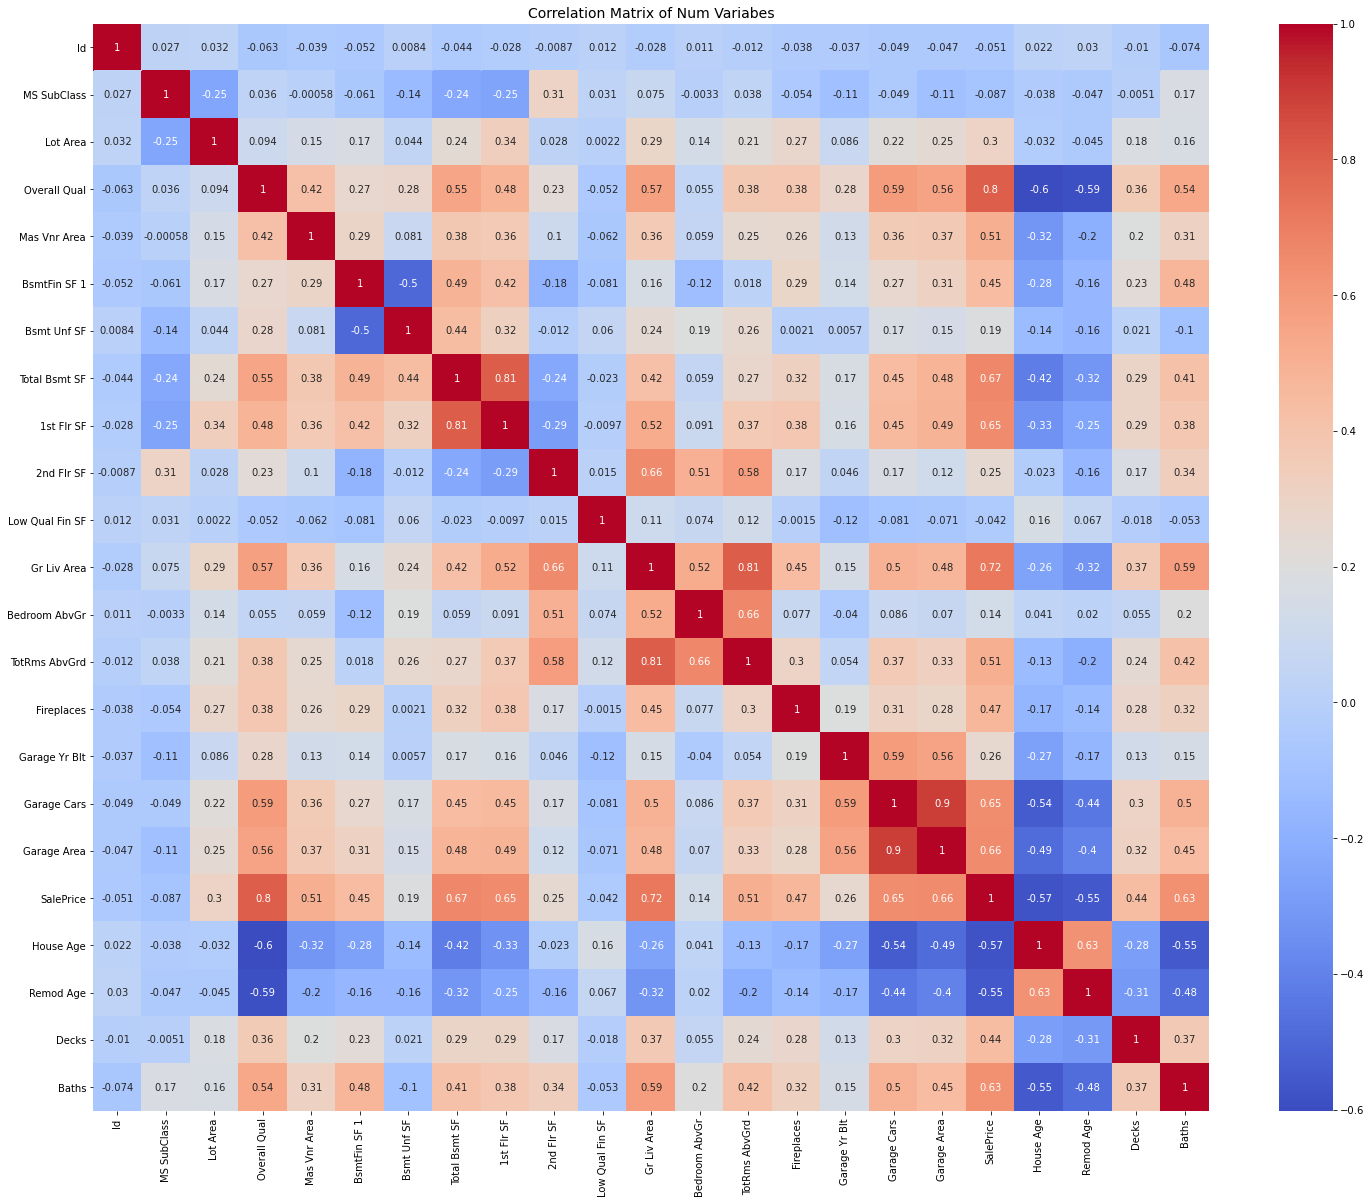

In [85]:
plt.figure(figsize = (25,20))
plt.title('Correlation Matrix of Num Variabes', fontsize = 14)
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

* We see that there is a high correlation between 'Tot Rms Abv Grd' and 'Gr Liv Area' (0.81). This is understandable as the more rooms you have, the bigger your living space will be and vice versa. We will drop 'Tot Rms Abv Grd' given that it has a lower correlation and also 'Gr Liv Area' being continuos will help improve accuracy.
* There is a high correlation between 'Garage Area' and 'Garage Cars' (0.9). This is certainly the case as both measure the same thing but with different scales. We see that 'Garage Area' has a higher correlation to 'SalePrice' and we will drop 'Garage Cars' due to its slightly lower correlation and 'Garage Area' being a continuous variable.
* We also see that '1st Flr SF' is highly correlated to 'Total Bsmt SF'. This is understandable as you can only build so much basement as you have the first floor. We might be tempted to drop either but taking a step back, these 2 measure very different things from a home buyer's point of view and we will keep both.
* Lastly, we see that 'Gr Liv Area' is somewhat correlated to '1st Flr SF' and '2nd Flr SF', we will run some tests to see if the total above ground living area is equal to the sum of living area on the first 2 floors.

In [86]:
# We examine if 1st and 2nd flr SF is equivalent to above ground SF
first_flr_train = df['1st Flr SF']
first_flr_test = df_test['1st Flr SF']
second_flr_train = df['2nd Flr SF']
second_flr_test = df_test['2nd Flr SF']
combined_flr_train = first_flr_train + second_flr_train
combined_flr_test = first_flr_test + second_flr_test
diff_train = df['Gr Liv Area'] - combined_flr_train
diff_test = df_test['Gr Liv Area'] - combined_flr_test

In [87]:
# We then see the value counts for the difference list, if they are mostly the same, we should see a 
# ton of zeroes
diff_train.value_counts()

0       2013
80         3
205        2
390        1
697        1
572        1
528        1
515        1
514        1
513        1
512        1
479        1
473        1
450        1
436        1
397        1
371        1
384        1
53         1
362        1
360        1
312        1
259        1
234        1
156        1
144        1
140        1
120        1
114        1
108        1
1064       1
dtype: int64

In [88]:
# We do the same for the test set.
diff_test.value_counts()

0      872
80       1
232      1
360      1
392      1
420      1
431      1
481      1
dtype: int64

We thus see that they are almost always equal, we can drop the '1st Flr SF' and '2nd Flr SF' variables.

Similar to what we did earlier, we now drop these columns discussed.

In [89]:
# Create second list to drop for points discussed in section 5.2
list_to_drop_2 = ['TotRms AbvGrd', 'Garage Cars', '1st Flr SF', '2nd Flr SF']

In [90]:
df.drop(columns = list_to_drop_2, inplace = True)
df_test.drop(columns = list_to_drop_2, inplace = True)

In [91]:
print(df.shape)
print(df_test.shape)

(2046, 49)
(879, 48)


## <a name="sec_6"></a>Section 6: Secondary Variable Selection (Numeric Variables)
In this step, we zoom in onto the correlation matrix of numerical variables and we decide which columns to drop.
We will supplement this with our understanding of the variables as well.

For this section, we will use this as a general rule of thumb:

0 - .2 =  weak, slight

.2 - .4 = mild/modest

.4 - .6 = moderate

.6 - .8 = moderately strong

.8 - 1.0 = strong

We will drop all variables with correlation below 0.3.

[University of Washington Stat 231 Regression](http://faculty.washington.edu/ddbrewer/s231/s231regr.htm)

<AxesSubplot:>

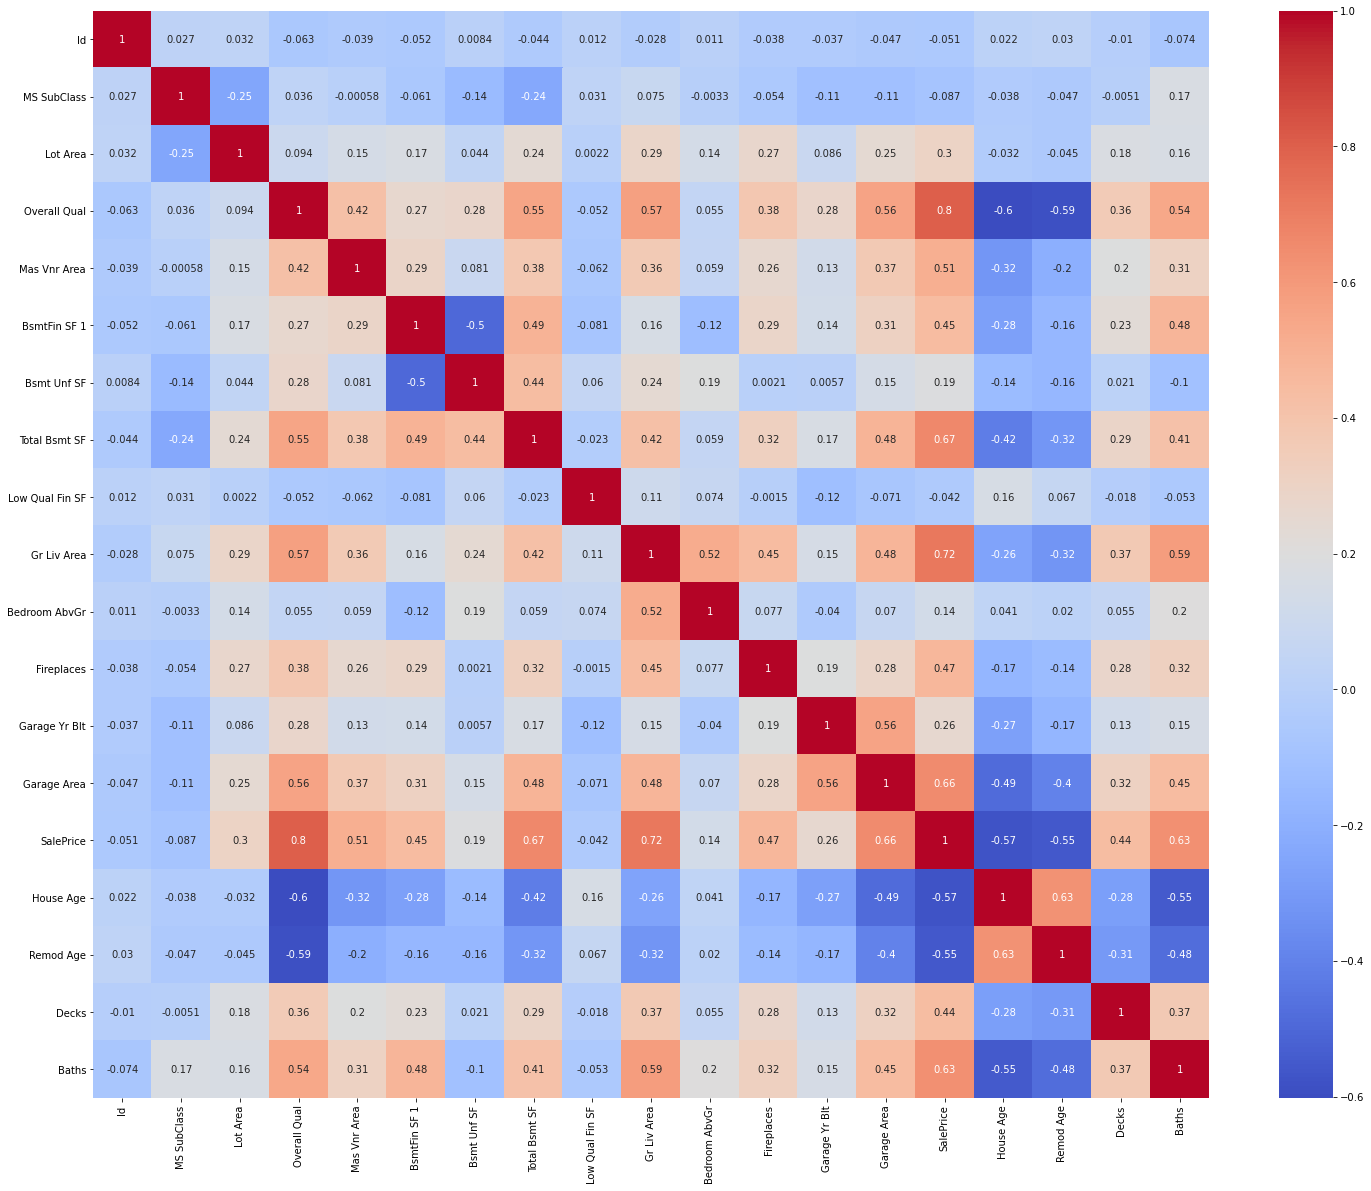

In [92]:
plt.figure(figsize = (25,20))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

Looking at the heatmap above, we can use the correlations to help us drop more variables. It is useful to note that we cannot simply drop all variables with low correlations. We have to supplement this decision with information from the data dictionary.

We keep Id as it will be used for referencing.
We keep MS SubClass as well as although it is numerical, it is actually a categorical feature and we will handle it later on.

We can drop 'Bsmt Unf SF', 'Low Qual Fin SF', 'Bedroom AbvGr', 'Garage Yr Built'.

In [93]:
# Create a new list of columns to drop
# Do note that we keep Id as a referencing tool
# We also keep MS SubClass as it could be a categorical variable
list_to_drop_3 = ['Bsmt Unf SF', 'Low Qual Fin SF', 'Bedroom AbvGr', 'Garage Yr Blt']

In [94]:
df.drop(columns = list_to_drop_3, inplace = True)
df_test.drop(columns = list_to_drop_3, inplace = True)

We now conclude this step with **12 numeric variables** that we will be using in our model.

## <a name="sec_7"></a>Section 7: Feature Engineering (Categorical Variables)

Now we switch gears and look to the categorical variables in our dataset. Looking ahead, we are aware of the fact that there will be some categorical variables which will prove to be useful in predcting SalePrice. However, before we engineer the features (be it imputing, creating dummies etc) we first have to conduct some primary observation on our data to drop categorical variables which are quite obviously not going to be useful.

### 7.1 Dropping Categorical Features

In [95]:
# We first create a list of the categorical variables we are looking at
cat_features = ['MS SubClass', 'MS Zoning', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
                'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'BsmtFin Type 1', 'BsmtFin Type 2',
     'Heating QC', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Type',
       'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Sale Type',]

Our first cut should be looking at whether any of the columns possess majority of the same values

In [96]:
# We create a funciton that lets us iterate through the list and returns the value counts of both the
# train and test data set
def value_counts(df_list, col):

    print("Column: %10s " % col)
    for i in range(len(df_list)):
        print("%20s" % ("Dataframe "+str(i)), end=" ")
    print("\n")

    for val in df_list[0][col].value_counts().index:
        i = 0
        for df in df_list:
            if i == len(df_list) - 1:
                print("%10s %10s" % (val, df[df[col]==val][col].count()))
            else:
                print("%10s %10s" % (val, df[df[col]==val][col].count()), end =" ")                    
            i += 1
    print("\n")

In [97]:
for _ in cat_features:
    value_counts([df, df_test], _)

Column: MS SubClass 
         Dataframe 0          Dataframe 1 

        20        767         20        309
        60        393         60        181
        50        198         50         89
       120        132        120         60
        30        101         30         38
        70         89         70         38
       160         88        160         41
        80         86         80         32
        90         75         90         34
       190         46        190         15
        85         28         85         20
        75         16         75          7
        45         11         45          7
       180         11        180          6
        40          4         40          2
       150          1        150          0


Column:  MS Zoning 
         Dataframe 0          Dataframe 1 

        RL       1595         RL        675
        RM        314         RM        146
        FV        101         FV         38
   C (all)         19    C (all) 

       GLQ        613        GLQ        244
       Unf        603        Unf        248
       ALQ        292        ALQ        136
       BLQ        200        BLQ         69
       Rec        183        Rec        105
       LwQ        102        LwQ         52
        NA         53         NA         25


Column: BsmtFin Type 2 
         Dataframe 0          Dataframe 1 

       Unf       1746        Unf        750
       Rec         80        Rec         26
       LwQ         60        LwQ         29
        NA         53         NA         25
       BLQ         48        BLQ         20
       ALQ         35        ALQ         18
       GLQ         24        GLQ         11


Column: Heating QC 
         Dataframe 0          Dataframe 1 

        Ex       1062         Ex        430
        TA        595         TA        267
        Gd        319         Gd        157
        Fa         67         Fa         25
        Po          3         Po          0


Column: Kitchen Qual 
    

There a number of columns above that have majority same values. We can drop this as this will skew our data and model. We list these columns below. We also do note that out of the 3 pairs of our potential interaction terms for categorical features, either one or both from each pair is in the list to drop so we will not have to generate any interaction terms for categorical features later on.

In [98]:
# We can drop a few columns
list_to_drop_4 = ['Land Contour', 'Utilities', 'Land Slope', 'Condition 2', 
                  'Exter Cond', 'Bsmt Cond', 'BsmtFin Type 2',
                  'Functional', 'Garage Qual', 'Garage Cond', 'Sale Type']

In [99]:
df.drop(columns = list_to_drop_4, inplace = True)
df_test.drop(columns = list_to_drop_4, inplace = True)

In [100]:
# We refine our categorical features list
cat_features_2 =['MS SubClass', 'MS Zoning', 'Lot Shape',
       'Lot Config', 'Neighborhood',
       'Condition 1', 'Bldg Type', 'House Style',
        'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
        'Exter Qual', 'Foundation', 'Bsmt Qual',
        'BsmtFin Type 1',
       'Heating QC', 'Kitchen Qual',
       'Fireplace Qu', 'Garage Type',
       'Garage Finish']

### 7.2 EDA of Categorical Features

With the list of categorical features we have, we conduct EDA on these columns to get a better sensing of which variables we should focus on and which we can disregard.

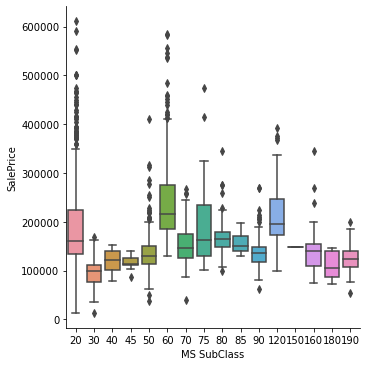

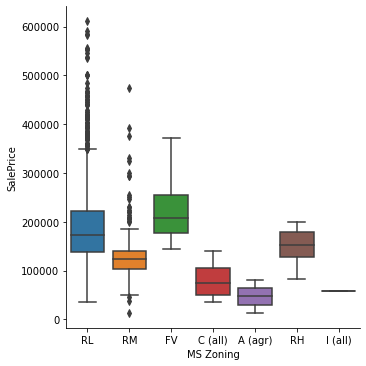

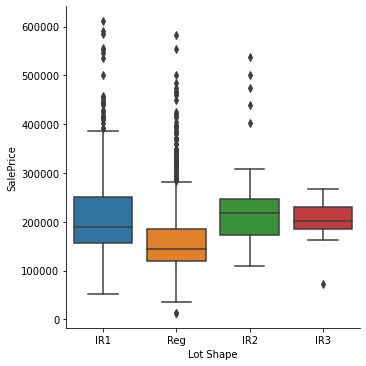

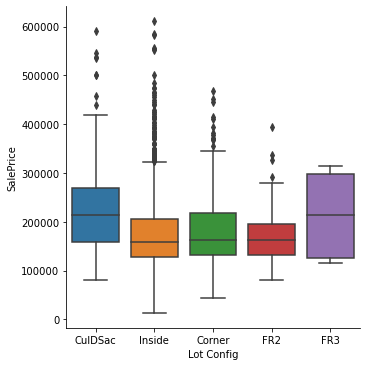

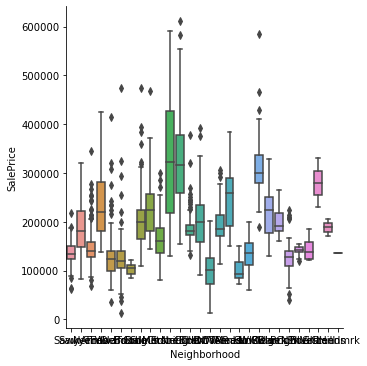

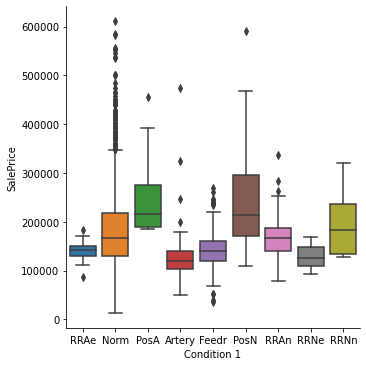

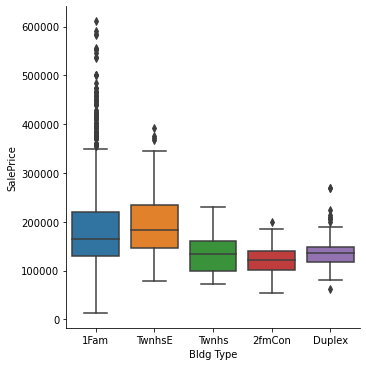

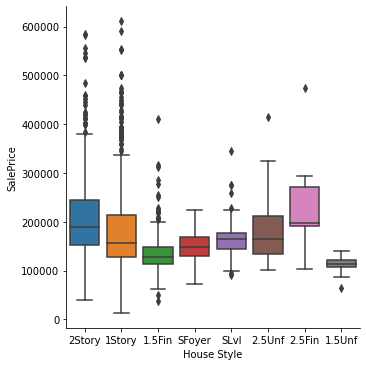

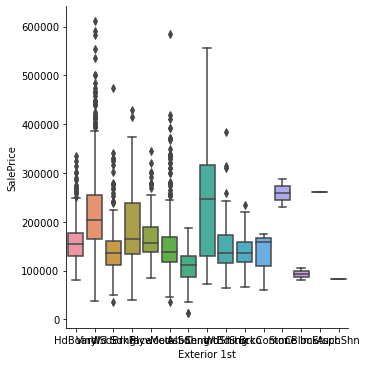

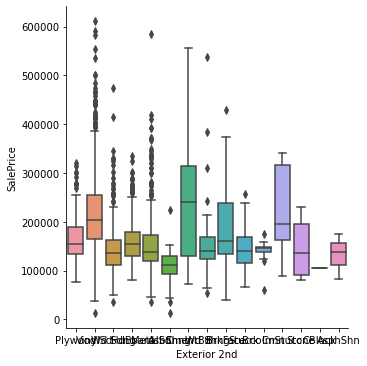

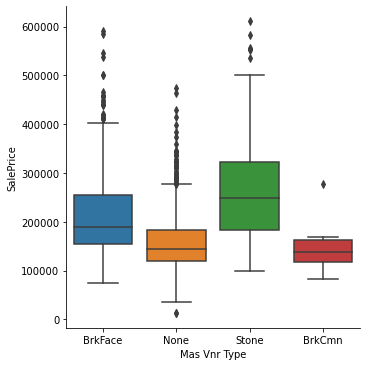

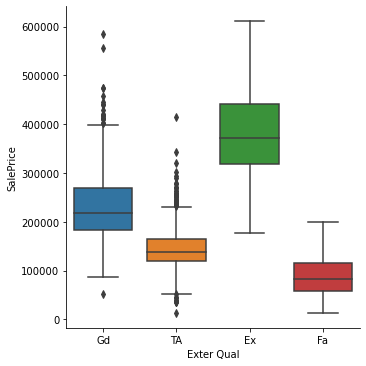

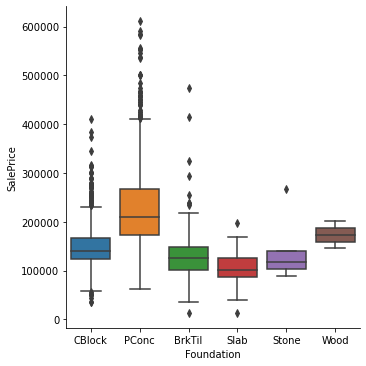

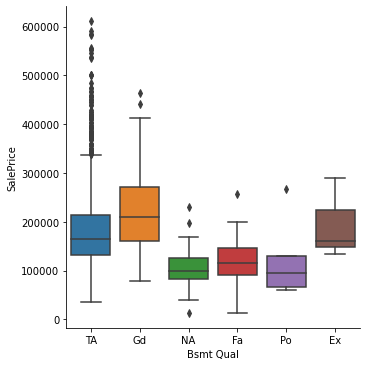

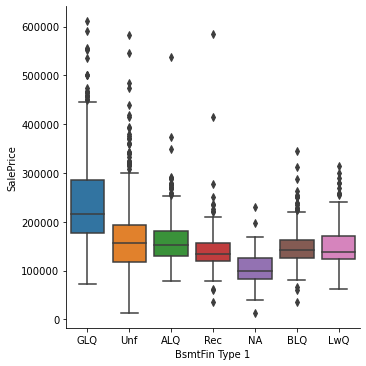

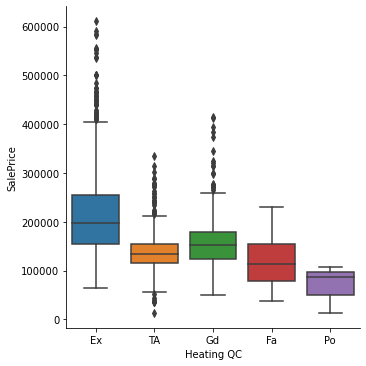

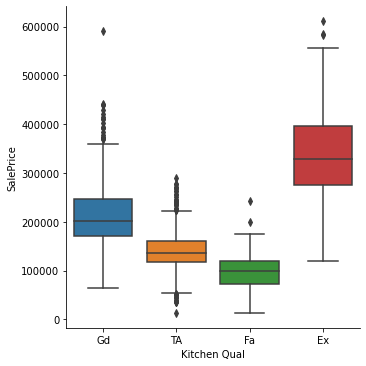

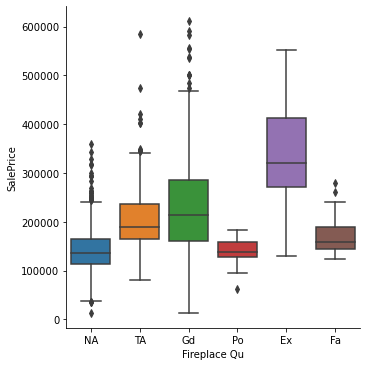

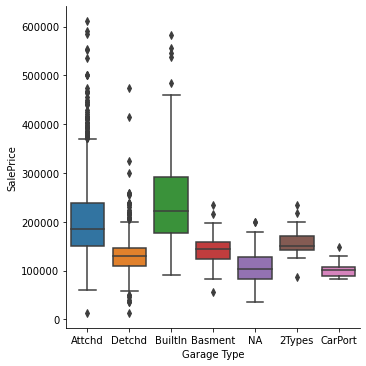

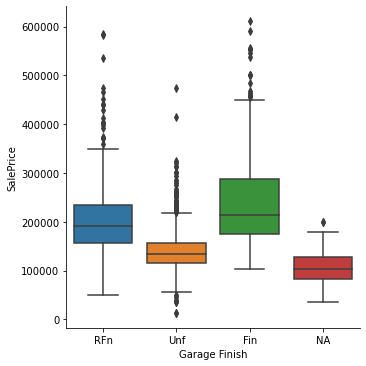

In [101]:
for i in cat_features_2:
    ax = sns.catplot(x=i, y = 'SalePrice', kind = 'box', data = df)

Given that we have quite a few variables to work with, we will create a simple table to keep track of our observations.

|Variable|Observations|Relevance/ Importance|Data Type|
|---|---|---|---|
|**MS SubClass**|Quite distinct between cats|More refined grouping needed|Nominal|
|**MS Zoning**|Distinct between categories|Re-assignment needed|Nominal|
|**Lot Shape**|Not much distinct characteristic|Inconclusive|Ordinal|
|**Lot Config**|No distinct relationship|Drop|Nominal|
|**Neighborhood**|Distinct categories|More refined grouping needed|Nominal|
|**Condition 1**|Distinct Categories|More refined grouping|Nominal|
|**Bldg Type**|No distinct categories|Drop|Nominal|
|**House Style**|Distinct categories|Some refined grouping needed|Nominal|
|**Exterior 1st**|Distinct categories|More refined grouping needed|Nominal|
|**Exterior 2nd**|Distinct categories|More refined grouping needed|Nominal|
|**Mas Vnr Type**|Distinct categories|More refinement needed|Nominal|
|**Exter Qual**|Distinct categories|Impute|Ordinal|
|**Foundation**|Inconclusive|Investigate further|Nominal|
|**Bsmt Qual**|Some distinct qualities|Impute|Ordinal|
|**BsmtFin Type 1**|Some distinction|Refine grouping|Ordinal|
|**Heating QC**|Distinct categories|Impute|Ordinal|
|**Kitchen Qual**|Distinct qualities|Impute|Ordinal|
|**Fireplace Qu**|Distinct qualities|Impute|Ordinal|
|**Garage Type**|Distinct categories|Refine grouping|Nominal|
|**Garage Finish**|Distinct categories|Impute|Ordinal|

Before we move forward to refine the categorical columns, we can drop some of them first. These are 'Lot Config' and 'Bldg Type' which do not have much distinction in relation to Sale Price.

In [102]:
# We create a list to drop these columns
list_to_drop_5 = ['Lot Config', 'Bldg Type']

In [103]:
df.drop(columns = list_to_drop_5, inplace = True)
df_test.drop(columns = list_to_drop_5, inplace = True)

### 7.3 Feature Engineering on Categorical Variables (ordinal)

With the remaining columns that we have, we have to convert these variables to numeric data in order for us to pass them through a model. For ordinal variables, we can just assign numbers to these columns. We will stick with the convention of the dataset whereby a higher number would indicate better quality. As for nominal variables, we will have to look more closely and see if we can refine groupings and index these variables.

In [104]:
# We first look at the ordinal categorical columns we have to deal with
ordinal_cat_features = ['Lot Shape', 'Exter Qual', 'Bsmt Qual', 
                       'BsmtFin Type 1', 'Heating QC', 'Kitchen Qual',
                       'Fireplace Qu', 'Garage Finish']

In [105]:
# We use the previous value counts function to look at the values these variables take
for _ in ordinal_cat_features:
    value_counts([df, df_test], _)

Column:  Lot Shape 
         Dataframe 0          Dataframe 1 

       Reg       1294        Reg        564
       IR1        689        IR1        287
       IR2         55        IR2         21
       IR3          8        IR3          7


Column: Exter Qual 
         Dataframe 0          Dataframe 1 

        TA       1244         TA        552
        Gd        697         Gd        292
        Ex         79         Ex         26
        Fa         26         Fa          9


Column:  Bsmt Qual 
         Dataframe 0          Dataframe 1 

        TA       1831         TA        782
        Gd         89         Gd         33
        Fa         65         Fa         39
        NA         53         NA         25
        Po          5         Po          0
        Ex          3         Ex          0


Column: BsmtFin Type 1 
         Dataframe 0          Dataframe 1 

       GLQ        613        GLQ        244
       Unf        603        Unf        248
       ALQ        292        A

In [106]:
# Replace values for Lot Shape
df['Lot Shape'].replace({'Reg': 4,
                    'IR1': 3,
                    'IR2': 2,
                    'IR3': 1}, inplace=True)

df_test['Lot Shape'].replace({'Reg': 4,
                    'IR1': 3,
                    'IR2': 2,
                    'IR3': 1}, inplace=True)

In [107]:
# Replace values for Exter Qual
df['Exter Qual'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1}, inplace =True)

df_test['Exter Qual'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1}, inplace =True)

In [108]:
# Replace values for Bsmt Qual
df['Bsmt Qual'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1,
                        'NA': 0}, inplace =True)

df_test['Bsmt Qual'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1,
                             'NA': 0}, inplace =True)

In [109]:
# Replace values for BsmtFin Type 1
df['BsmtFin Type 1'].replace({'GLQ': 6,
                             'ALQ': 5,
                             'BLQ': 4,
                             'Rec': 3,
                             'LwQ': 2,
                             'Unf': 1,
                             'NA': 0}, inplace =True)

df_test['BsmtFin Type 1'].replace({'GLQ': 6,
                             'ALQ': 5,
                             'BLQ': 4,
                             'Rec': 3,
                             'LwQ': 2,
                             'Unf': 1,
                             'NA': 0}, inplace =True)

In [110]:
# Replace values for Heating QC
df['Heating QC'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1}, inplace =True)

df_test['Heating QC'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1}, inplace =True)

In [111]:
# Replace values for Kitchen Qual
df['Kitchen Qual'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1}, inplace =True)

df_test['Kitchen Qual'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1}, inplace =True)

In [112]:
# Replace values for Fireplace Qu
df['Fireplace Qu'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1,
                        'NA': 0}, inplace =True)

df_test['Fireplace Qu'].replace({'Ex': 5,
                         'Gd': 4,
                         'TA': 3,
                         'Fa': 2,
                         'Po': 1,
                             'NA': 0}, inplace =True)

In [113]:
# Replace values for Garage Finish
df['Garage Finish'].replace({'Fin': 3,
                            'RFn': 2,
                            'Unf': 1,
                            'NA': 0}, inplace =True)

df_test['Garage Finish'].replace({'Fin': 3,
                            'RFn': 2,
                            'Unf': 1,
                            'NA': 0}, inplace =True)

In [114]:
# We plot these out in a heatmap to check
tempdf = df[['Lot Shape', 'Exter Qual', 'Bsmt Qual', 
                       'BsmtFin Type 1', 'Heating QC', 'Kitchen Qual',
                       'Fireplace Qu', 'Garage Finish', 'SalePrice']]

<AxesSubplot:>

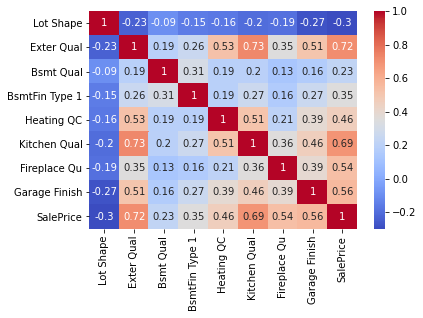

In [115]:
sns.heatmap(tempdf.corr(), annot = True, cmap = 'coolwarm')

We see that all these variables have decent correlation to SalePrice, we will keep these in place.

### 7.4 Feature Engineering on Categorical Variables (nominal)

We now move on to the nominal features. For these features, we cannot simply apply the same technique as before as the categories are not split in any form of order. We will have to use additional EDA and analysis to see how we can best transform and engineer these features.

We will be using both the box plots above and correlation data for our re-assignment. We did try to assign values of 0, 1, 2 etc to different groups but found that using -1, 1 and 0 worked better.

In [116]:
# Let's start off with listing the variables we have interest in
nominal_cat_features =['MS SubClass', 'MS Zoning', 
        'Neighborhood', 'Condition 1', 'House Style',
        'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
         'Foundation', 'Garage Type']

With each variable, not all the categories within will prove to be useful. We will create dummies for each and then evaluate the relevance and convert the meaningful variables.

In [117]:
# We defince a function that pulls out each variable and the Saleprice into a temp dataframe 
# and returns us correlation of dummies
def cat_feature_corr(df, x, y):
    df_new = df[[x, y]]
    df_new = pd.get_dummies(df_new, columns = [x], drop_first = False)
    return df_new.corr()['SalePrice'].T

In [118]:
cat_feature_corr(df, 'MS SubClass', 'SalePrice')

SalePrice          1.000000
MS SubClass_20     0.076578
MS SubClass_30    -0.248837
MS SubClass_40    -0.034824
MS SubClass_45    -0.060401
MS SubClass_50    -0.182619
MS SubClass_60     0.356370
MS SubClass_70    -0.075630
MS SubClass_75     0.026187
MS SubClass_80    -0.031510
MS SubClass_85    -0.040265
MS SubClass_90    -0.103844
MS SubClass_120    0.100451
MS SubClass_150   -0.009232
MS SubClass_160   -0.115115
MS SubClass_180   -0.066615
MS SubClass_190   -0.109406
Name: SalePrice, dtype: float64

We see that subclass 30 (-0.24), subclass 60 (0.35) are the significant ones. We will replace MS SubClass 30 with -1, MS SubClass 60 with 1 and all others with 0.

In [119]:
df['MS SubClass'] = df['MS SubClass'].apply(lambda x:1 if x == 60 else -1 if x == 30 else 0)
df_test['MS SubClass'] = df_test['MS SubClass'].apply(lambda x:1 if x == 60 else -1 if x == 30 else 0)

In [120]:
cat_feature_corr(df, 'MS Zoning', 'SalePrice')

SalePrice            1.000000
MS Zoning_A (agr)   -0.052956
MS Zoning_C (all)   -0.126394
MS Zoning_FV         0.106727
MS Zoning_I (all)   -0.034556
MS Zoning_RH        -0.034173
MS Zoning_RL         0.230301
MS Zoning_RM        -0.280848
Name: SalePrice, dtype: float64

We see that MS Zoning RL (0.23) and MS Zoning RM (-0.28) are significant. We will assign them values of 1 and -1 respectively.

In [121]:
df['MS Zoning'] = df['MS Zoning'].apply(lambda x:1 if x == "RL" else -1 if x == 'RM' else 0)
df_test['MS Zoning'] = df_test['MS Zoning'].apply(lambda x:1 if x == 'RL' else -1 if x == 'RM' else 0)

We now look to the nieghborhoods variables.

In [122]:
cat_feature_corr(df, 'Neighborhood', 'SalePrice')

SalePrice               1.000000
Neighborhood_Blmngtn    0.024890
Neighborhood_Blueste   -0.025265
Neighborhood_BrDale    -0.095419
Neighborhood_BrkSide   -0.132473
Neighborhood_ClearCr    0.052515
Neighborhood_CollgCr    0.082297
Neighborhood_Crawfor    0.058382
Neighborhood_Edwards   -0.180165
Neighborhood_Gilbert    0.023923
Neighborhood_Greens     0.003468
Neighborhood_GrnHill    0.038873
Neighborhood_IDOTRR    -0.189755
Neighborhood_Landmrk   -0.012413
Neighborhood_MeadowV   -0.111690
Neighborhood_Mitchel   -0.035668
Neighborhood_NAmes     -0.189722
Neighborhood_NPkVill   -0.047365
Neighborhood_NWAmes     0.034895
Neighborhood_NoRidge    0.263587
Neighborhood_NridgHt    0.448999
Neighborhood_OldTown   -0.208664
Neighborhood_SWISU     -0.074318
Neighborhood_Sawyer    -0.133890
Neighborhood_SawyerW    0.016660
Neighborhood_Somerst    0.150144
Neighborhood_StoneBr    0.257167
Neighborhood_Timber     0.116458
Neighborhood_Veenker    0.083232
Name: SalePrice, dtype: float64

We see that there are a handful of neihborhoods we are interested in. We plot a larger box plot for this to get into the details.

<AxesSubplot:xlabel='SalePrice', ylabel='Neighborhood'>

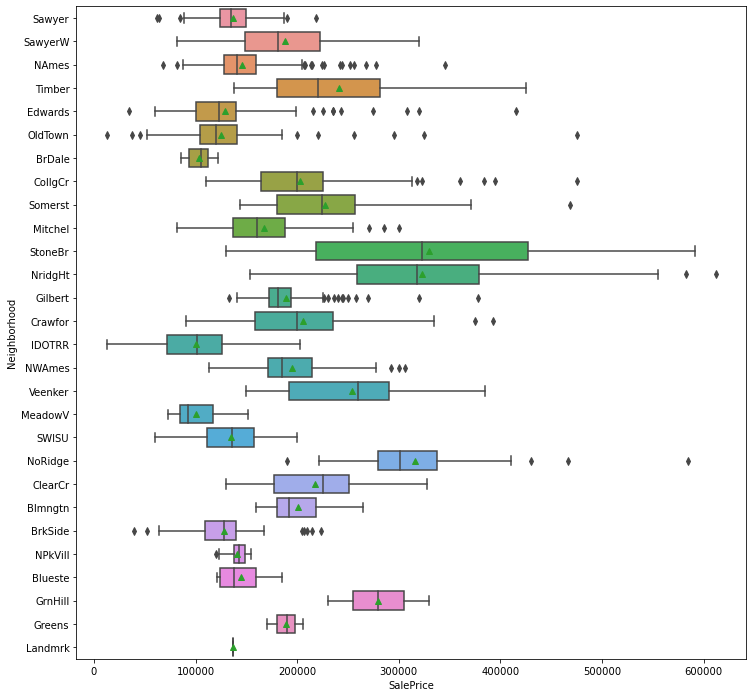

In [123]:
plt.figure(figsize=(12,12))   
sns.boxplot(x = 'SalePrice', y='Neighborhood', data = df, showmeans = True)


We can make a few observations from the plots and data:

* We have some neighborhoods that belong in the upper price range: NoRidge, NridgHt, StoneBr
* On the other hand, we have some neighborhoods that fetch a lower price: Edwards, IDOTRR, OldTown, BrDale, MeadowV, SWISU, BrkSide

We ran the model with assigning 1 to more expensive neighborhoods, -1 and others with 0 but upon investigation, assigning dummies gives us better results. This is probably due to the fact that there are just too many neighborhoods to account for.


In [124]:
# We get dummies for the neighbodhood variable
df = pd.get_dummies(df, columns = ['Neighborhood'], drop_first = False)

In [125]:
df_test = pd.get_dummies(df_test, columns = ['Neighborhood'], drop_first = False)

We then look at Condition 1.

In [126]:
cat_feature_corr(df, 'Condition 1', 'SalePrice')

SalePrice             1.000000
Condition 1_Artery   -0.125202
Condition 1_Feedr    -0.112101
Condition 1_Norm      0.109714
Condition 1_PosA      0.070970
Condition 1_PosN      0.106938
Condition 1_RRAe     -0.053711
Condition 1_RRAn     -0.015007
Condition 1_RRNe     -0.025079
Condition 1_RRNn      0.011436
Name: SalePrice, dtype: float64

We do not see any meaningful relation. we will drop this value. 

In [127]:
# Once again, we create a list to hold columns we want to drop.
list_to_drop_6 = ['Condition 1']

In [128]:
cat_feature_corr(df, 'House Style', 'SalePrice')

SalePrice             1.000000
House Style_1.5Fin   -0.196107
House Style_1.5Unf   -0.066887
House Style_1Story   -0.022047
House Style_2.5Fin    0.042538
House Style_2.5Unf    0.010777
House Style_2Story    0.202902
House Style_SFoyer   -0.064194
House Style_SLvl     -0.042204
Name: SalePrice, dtype: float64

We see a meaningful numbers for 1.5Fin and 2Story. We replace 1.5fin with -1, 2Story with 1 and the rest, 0.

In [129]:
df['House Style'] = df['House Style'].apply(lambda x:1 if x == '2Story' else -1 if x == '1.5 Fin' else 0)
df_test['House Style'] = df_test['House Style'].apply(lambda x:1 if x == '2Story' else -1 if x == '1.5 Fin' else 0)

We move to look at Exterior 1st and 2nd

In [130]:
cat_feature_corr(df, 'Exterior 1st', 'SalePrice')

SalePrice               1.000000
Exterior 1st_AsbShng   -0.126492
Exterior 1st_AsphShn   -0.027651
Exterior 1st_BrkComm   -0.024410
Exterior 1st_BrkFace    0.026210
Exterior 1st_CBlock    -0.034823
Exterior 1st_CemntBd    0.168429
Exterior 1st_HdBoard   -0.114581
Exterior 1st_ImStucc    0.022459
Exterior 1st_MetalSd   -0.148615
Exterior 1st_Plywood   -0.041802
Exterior 1st_Stone      0.030389
Exterior 1st_Stucco    -0.060916
Exterior 1st_VinylSd    0.342451
Exterior 1st_Wd Sdng   -0.191800
Exterior 1st_WdShing   -0.048956
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Exterior 1st'>

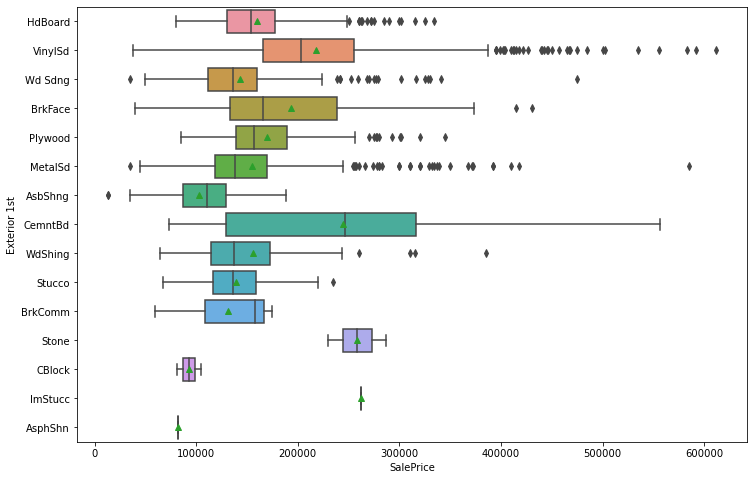

In [131]:
# We plot a larger boxplot to get a clearer picture
plt.figure(figsize=(12,8))   
sns.boxplot(x = 'SalePrice', y='Exterior 1st', data = df, showmeans = True)


We assign 1 to CemntBd, Vinylsd and Stone. We assign -1 to AsbShng, AsphShn, Wd Sdng, CBlock, BrkComm. 

In [132]:
good_ex = ['CmntBd', 'VinylSd', 'Stone']
bad_ex = ['AsbShng', 'AsphShn', 'Wd Sdng', 'CBlock', 'BrkComm']
df['Exterior 1st'] = df['Exterior 1st'].apply(lambda x:1 if x in good_ex else -1 if x in bad_ex else 0)
df_test['Exterior 1st'] = df_test['Exterior 1st'].apply(lambda x:1 if x in good_ex else -1 if x in bad_ex else 0)

In [133]:
cat_feature_corr(df, 'Exterior 2nd', 'SalePrice')

SalePrice               1.000000
Exterior 2nd_AsbShng   -0.110538
Exterior 2nd_AsphShn   -0.023866
Exterior 2nd_Brk Cmn   -0.047963
Exterior 2nd_BrkFace    0.010658
Exterior 2nd_CBlock    -0.021340
Exterior 2nd_CmentBd    0.157849
Exterior 2nd_HdBoard   -0.102690
Exterior 2nd_ImStucc    0.042647
Exterior 2nd_MetalSd   -0.139624
Exterior 2nd_Plywood   -0.061558
Exterior 2nd_Stone     -0.024680
Exterior 2nd_Stucco    -0.051722
Exterior 2nd_VinylSd    0.337860
Exterior 2nd_Wd Sdng   -0.173269
Exterior 2nd_Wd Shng   -0.061273
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Exterior 2nd'>

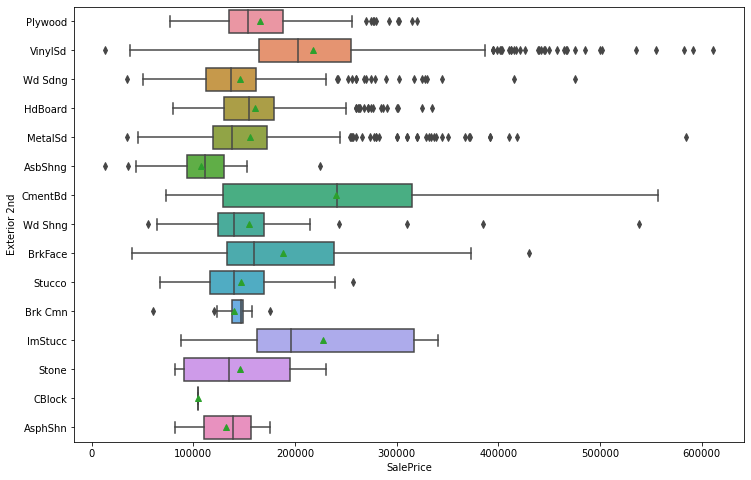

In [134]:
# We plot a larger boxplot to get a clearer picture
plt.figure(figsize=(12,8))   
sns.boxplot(x = 'SalePrice', y='Exterior 2nd', data = df, showmeans = True)


We assign 1 to VinylSd and CmentBd We assign -1 to MetalSd, Wd Shng, AsbShng, CBlock and AsphShn 

In [135]:
good_ex2 = ['CmntBd', 'VinylSd']
bad_ex2 = ['AsbShng', 'AsphShn', 'Wd Sdng', 'CBlock', 'MetalSd']
df['Exterior 2nd'] = df['Exterior 2nd'].apply(lambda x:1 if x in good_ex else -1 if x in bad_ex else 0)
df_test['Exterior 2nd'] = df_test['Exterior 2nd'].apply(lambda x:1 if x in good_ex else -1 if x in bad_ex else 0)

In [136]:
cat_feature_corr(df, 'Mas Vnr Type', 'SalePrice')

SalePrice               1.000000
Mas Vnr Type_BrkCmn    -0.037304
Mas Vnr Type_BrkFace    0.258067
Mas Vnr Type_None      -0.412032
Mas Vnr Type_Stone      0.312371
Name: SalePrice, dtype: float64

We assign 1 to BrkFace and Stone and -1 to None

In [137]:
df['Mas Vnr Type'] = df['Mas Vnr Type'].apply(lambda x:1 if x == 'BrkFace' else -1 if x == 'None' else 1 if x == 'Stone' else 0)
df_test['Mas Vnr Type'] = df_test['Mas Vnr Type'].apply(lambda x:1 if x == 'BrkFace' else -1 if x == 'None' else 1 if x == 'Stone' else 0)

We then look at Foundation

In [138]:
cat_feature_corr(df, 'Foundation', 'SalePrice')

SalePrice            1.000000
Foundation_BrkTil   -0.230083
Foundation_CBlock   -0.356421
Foundation_PConc     0.531428
Foundation_Slab     -0.126012
Foundation_Stone    -0.023889
Foundation_Wood     -0.003056
Name: SalePrice, dtype: float64

We assign -1 to BrkTil, CBlock and Slab and 1 to PConc.

In [139]:
good_found = ['PConc'] 
bad_found = ['BrkTil', 'CBlock', 'Slab']
df['Foundation'] = df['Foundation'].apply(lambda x:1 if x in good_found else -1 if x in bad_found else 0)
df_test['Foundation'] = df_test['Foundation'].apply(lambda x:1 if x in good_found else -1 if x in bad_found else 0)

Lastly, we look at Garage Type

In [140]:
cat_feature_corr(df, 'Garage Type', 'SalePrice')

SalePrice              1.000000
Garage Type_2Types    -0.029692
Garage Type_Attchd     0.357209
Garage Type_Basment   -0.055805
Garage Type_BuiltIn    0.219952
Garage Type_CarPort   -0.072041
Garage Type_Detchd    -0.369589
Garage Type_NA        -0.231282
Name: SalePrice, dtype: float64

We assign 1 to Attchd, BuiltIn and -1 for Detchd and NA.

In [141]:
good_garage = ['Attchd', 'BuiltIn']
bad_garage = ['Detchd', 'NA']
df['Garage Type'] = df['Garage Type'].apply(lambda x:1 if x in good_garage else -1 if x in bad_garage else 0)
df_test['Garage Type'] = df_test['Garage Type'].apply(lambda x:1 if x in good_garage else -1 if x in bad_garage else 0)

In [142]:
# We remember to drop the columns as well
df.drop(columns = list_to_drop_6, inplace = True)
df_test.drop(columns = list_to_drop_6, inplace = True)

## <a name="sec_8"></a>Section 8: Summary of Variables

Now we have our final list of variables. We check to see if we have meaninful variables


### 8.1 Correlation Heatmap

We plot a quick heatmap to look at our correlation data

<AxesSubplot:>

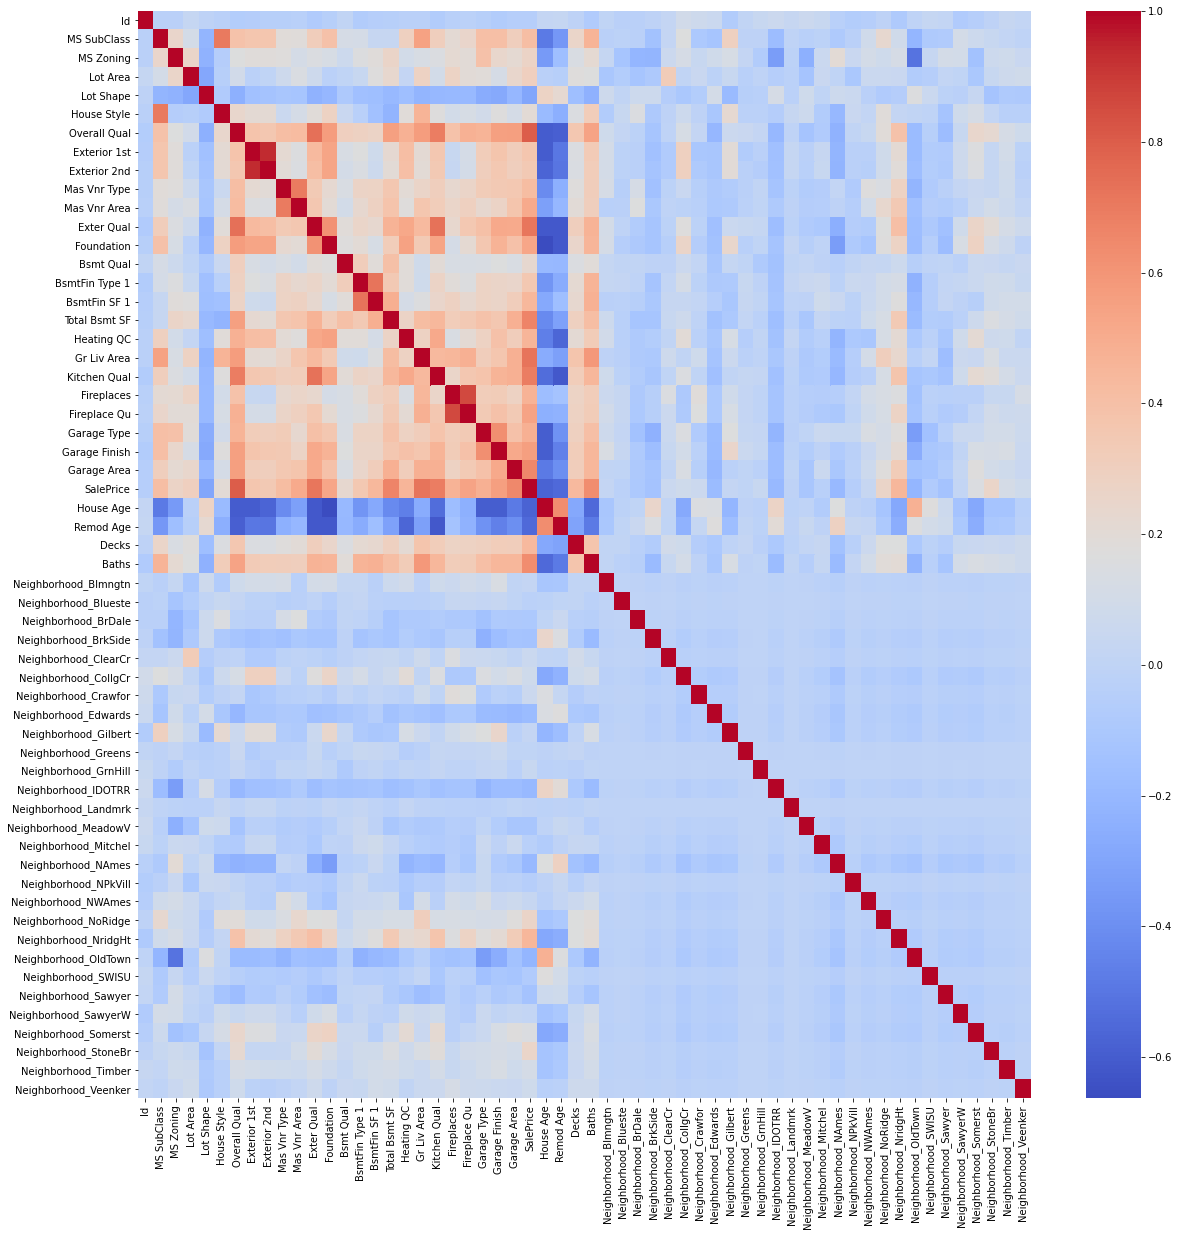

In [144]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap = 'coolwarm')

Our heatmap shows that all columns relating to SalePrice show meaningful correlation. Other than the dummy variables, we can see that all other variables either show significantly postive or negative correlation. We can now be comfortable that we are working with the right variables.

### 8.2 Splitting of Variables

Just for good measure, we define our continuos and categorical/ ordinal/ low scale variables into 2 lists. This is for us to use lest we need to scale our data later on

In [145]:
df.columns

Index(['Id', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Lot Shape',
       'House Style', 'Overall Qual', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Foundation', 'Bsmt Qual',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC',
       'Gr Liv Area', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Area', 'SalePrice', 'House Age',
       'Remod Age', 'Decks', 'Baths', 'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Ne

In [146]:
# Continuous variables
scale_needed = ['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
                 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'House Age',
                 'Remod Age', 'Decks' ]

In [147]:
# Categorical variables
no_scale = ['MS SubClass', 'MS Zoning', 'Lot Shape',
                'House Style', 'Overall Qual',
                'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                'Exter Qual', 'Foundation', 'Bsmt Qual', 'Bsmt Fin Type 1',
                'Heating QC', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
                'Garage Type', 'Garage Finish', 'Baths' ,
           'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']

## <a name="sec_9"></a>Section 9: Model Fitting

In the last step, we find the optimal model for us to use. We will run a few models and find the best model to use.
We will be using a simple Linear Regression, Ridge Regression, Lasso Regression and Elastic Net.

### 9.1 Initial Model Fitting

In [148]:
# Set up X and y variables 
X = df[['MS SubClass', 'MS Zoning', 'Lot Area', 'Lot Shape',
       'House Style', 'Overall Qual', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Foundation', 'Bsmt Qual',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC',
       'Gr Liv Area', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Area', 'House Age',
       'Remod Age', 'Decks', 'Baths', 'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']]
y = df['SalePrice']

In [149]:
# Next we do a train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [150]:
# We start off with a simple linear regression model
lr = LinearRegression()

In [151]:
# We fit our model
lr.fit(X_train, y_train)

LinearRegression()

In [152]:
# We find the mean squared error for this model
-cross_val_score(
    LinearRegression(),
    X_train,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

702024478.9319159

We know that we should standardise values when using ridge, lasso and elasticnet. But we will run this first without standardising for good measure.

In [153]:
ridgecv = RidgeCV(alphas = np.logspace(.1,100,100))
ridgecv.fit(X_train, y_train)

RidgeCV(alphas=array([1.25892541e+000, 1.28555573e+001, 1.31274937e+002, 1.34051824e+003,
       1.36887451e+004, 1.39783061e+005, 1.42739922e+006, 1.45759330e+007,
       1.48842609e+008, 1.51991108e+009, 1.55206209e+010, 1.58489319e+011,
       1.61841878e+012, 1.65265354e+013, 1.68761248e+014, 1.72331091e+015,
       1.75976447e+016, 1.79698915e+017, 1.83500125e+018, 1.87381742e+019,
       1.913454...
       6.17887047e+076, 6.30957344e+077, 6.44304121e+078, 6.57933225e+079,
       6.71850628e+080, 6.86062429e+081, 7.00574855e+082, 7.15394265e+083,
       7.30527154e+084, 7.45980152e+085, 7.61760031e+086, 7.77873705e+087,
       7.94328235e+088, 8.11130831e+089, 8.28288856e+090, 8.45809828e+091,
       8.63701425e+092, 8.81971488e+093, 9.00628020e+094, 9.19679199e+095,
       9.39133370e+096, 9.58999061e+097, 9.79284974e+098, 1.00000000e+100]))

In [154]:
# We calculate the ridge score
- cross_val_score(
    Ridge(alpha = ridgecv.alpha_),
    X_train,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

700174417.8093667

In [155]:
lassocv = LassoCV(n_alphas=200)
lassocv.fit(X_train, y_train)

LassoCV(n_alphas=200)

In [156]:
# We calculate the Lasso score
- cross_val_score(
    Lasso(alpha=lassocv.alpha_),
    X_train,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

1169563685.7063582

In [157]:
elasticcv = ElasticNetCV(l1_ratio = np.linspace(.01, 1, 5), n_alphas = 50)   
elasticcv.fit(X_train, y_train)

ElasticNetCV(l1_ratio=array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
             n_alphas=50)

In [158]:
# We calculate the elastic net score
- cross_val_score(
    ElasticNet(alpha=elasticcv.alpha_,
              l1_ratio = elasticcv.l1_ratio_),
    X_train,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

1169563685.7063582

We then move to use Lasso, Ridge and ElasticNet with standardising. We should only scale the columns that have large continuous variables.

In [159]:
# We bring back the 2 sets of variables.
# Continuous variables
scale_needed = ['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
                 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'House Age',
                 'Remod Age', 'Decks' ]

# Categorical variables
no_scale = ['MS SubClass', 'MS Zoning', 'Lot Shape',
                'House Style', 'Overall Qual',
                'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                'Exter Qual', 'Foundation', 'Bsmt Qual', 'Bsmt Fin Type 1',
                'Heating QC', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
                'Garage Type', 'Garage Finish', 'Baths' ,
           'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']

In [160]:
ss = StandardScaler()

In [161]:
# We rename the X_train and X_test set before we scale, this is done as we will be performing more transformations 
X_train_scaled = X_train
X_test_scaled = X_test

In [162]:
X_train_scaled[scale_needed] = ss.fit_transform(X_train_scaled[scale_needed])
X_test_scaled[scale_needed] = ss.transform(X_test_scaled[scale_needed])

In [163]:
ridgecv = RidgeCV(alphas = np.logspace(.1,100,100))
ridgecv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.25892541e+000, 1.28555573e+001, 1.31274937e+002, 1.34051824e+003,
       1.36887451e+004, 1.39783061e+005, 1.42739922e+006, 1.45759330e+007,
       1.48842609e+008, 1.51991108e+009, 1.55206209e+010, 1.58489319e+011,
       1.61841878e+012, 1.65265354e+013, 1.68761248e+014, 1.72331091e+015,
       1.75976447e+016, 1.79698915e+017, 1.83500125e+018, 1.87381742e+019,
       1.913454...
       6.17887047e+076, 6.30957344e+077, 6.44304121e+078, 6.57933225e+079,
       6.71850628e+080, 6.86062429e+081, 7.00574855e+082, 7.15394265e+083,
       7.30527154e+084, 7.45980152e+085, 7.61760031e+086, 7.77873705e+087,
       7.94328235e+088, 8.11130831e+089, 8.28288856e+090, 8.45809828e+091,
       8.63701425e+092, 8.81971488e+093, 9.00628020e+094, 9.19679199e+095,
       9.39133370e+096, 9.58999061e+097, 9.79284974e+098, 1.00000000e+100]))

In [164]:
# We find the optimal alpha
ridgecv.alpha_

1.2589254117941673

In [165]:
# We calculate the ridge score
- cross_val_score(
    Ridge(alpha = ridgecv.alpha_),
    X_train_scaled,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

700075695.8127872

In [166]:
# We move to use Lasso
lassocv = LassoCV(n_alphas=200)
lassocv.fit(X_train_scaled, y_train)

LassoCV(n_alphas=200)

In [167]:
# We look at the alpha
lassocv.alpha_

107.87800026084061

In [168]:
- cross_val_score(
    Lasso(alpha=lassocv.alpha_),
    X_train_scaled,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

698013339.8651533

In [169]:
# Then we move to use elasticnet
elasticcv = ElasticNetCV(l1_ratio = np.linspace(.01, 1, 5), n_alphas = 50)   
elasticcv.fit(X_train_scaled, y_train)

ElasticNetCV(l1_ratio=array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
             n_alphas=50)

In [170]:
# We find alpha
elasticcv.alpha_

104.41923152605317

In [171]:
# We find l1 ratio
elasticcv.l1_ratio_

1.0

In [172]:
- cross_val_score(
    ElasticNet(alpha=elasticcv.alpha_,
              l1_ratio = elasticcv.l1_ratio_),
    X_train_scaled,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

698040579.7323796

We present our findings in a table below:

|Model|StandardScaler|Mean Squared Error|
|---|---|---|
|**Linear Regression**|No|734410767.92|
|**Ridge Regression**|No|734143633.95|
|**Lasso Regression**|No|1169563685.70|
|**Elastic Net Regression**|No|1169563685.70|
|**Ridge Regression**|Yes|733657123.27|
|**Lasso Regression**|Yes|734691265.93|
|**Elastic Net Regression**|Yes|734691265.93|


### 9.2 Fine Tuning Model

We have seen that Lasso is the best model to use and rightly so, given that we have many variables and the model will penalise variables which are not useful. We try another round of model fitting but this time, we reference the coefficients in our Lasso model and remove those with Betas of 0. The reasonable assumption here is that ridge will now be the best model as we have dropped irrelevant variables and we can use the ridge regression to fine tune the betas better

In [174]:
# First we look at the coefficients of our variables
for i, name in enumerate(X):
    print(name, lassocv.coef_[i])

MS SubClass 0.0
MS Zoning 2357.0264939196704
Lot Area 7026.684458854462
Lot Shape 1419.4239661228492
House Style -603.0683787698854
Overall Qual 11625.921047299085
Exterior 1st 4544.678589882509
Exterior 2nd -4061.1221080560967
Mas Vnr Type -2973.1635762010405
Mas Vnr Area 6102.925943523416
Exter Qual 11570.359989603263
Foundation 1877.1893758775147
Bsmt Qual -2300.6771900742124
BsmtFin Type 1 -550.0870263448866
BsmtFin SF 1 11253.898555018
Total Bsmt SF 8750.777403726039
Heating QC 1579.619138755561
Gr Liv Area 22003.188514173416
Kitchen Qual 10821.352468016734
Fireplaces 794.6209676246154
Fireplace Qu 1152.2782258862735
Garage Type -896.2204967011593
Garage Finish 1629.9473581829886
Garage Area 4695.677413713712
House Age -5357.311643694046
Remod Age -3181.944542711909
Decks 2495.408318240134
Baths 71.89326587238999
Neighborhood_Blmngtn -0.0
Neighborhood_Blueste -0.0
Neighborhood_BrDale -0.0
Neighborhood_BrkSide 7956.142410420975
Neighborhood_ClearCr -0.0
Neighborhood_CollgCr -6099.9

We drop the columns with 0 as coefficients and redefine our X variable

In [175]:
# Set up new X and y variables 
X_new = df[['MS Zoning', 'Lot Area', 'Lot Shape',
       'House Style', 'Overall Qual', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Foundation', 'Bsmt Qual',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC',
       'Gr Liv Area', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Area', 'House Age',
       'Remod Age', 'Decks', 'Baths', 'Neighborhood_BrkSide',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert',
       'Neighborhood_GrnHill',  'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker']]
y = df['SalePrice']

In [176]:
# We bring back the 2 sets of variables.
# Continuous variables
scale_needed_new = ['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
                 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'House Age',
                 'Remod Age', 'Decks' ]

# Categorical variables
no_scale_new = [ 'MS Zoning', 'Lot Shape',
                'House Style', 'Overall Qual',
                'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                'Exter Qual', 'Foundation', 'Bsmt Qual', 'Bsmt Fin Type 1',
                'Heating QC', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
                'Garage Type', 'Garage Finish', 'Baths' ,
          'Neighborhood_BrkSide',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
        'Neighborhood_Gilbert',
       'Neighborhood_GrnHill', 'Neighborhood_Mitchel',  'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr',  'Neighborhood_Veenker']

In [177]:
# We perform our train test split
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new,y, random_state = 42)

In [178]:
# We start with a simple linear again
lr = LinearRegression()

In [179]:
lr.fit(X_train_new, y_train)

LinearRegression()

In [180]:
-cross_val_score(
    LinearRegression(),
    X_train_new,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

691132691.904433

We see an improvement in the baseline Linear Regression model. We move on to ridge, lasso and elastic net.

In [182]:
# First we scale our data
X_train_scaled_new = X_train_new
X_test_scaled_new = X_test_new

In [183]:
X_train_scaled_new[scale_needed_new] = ss.fit_transform(X_train_scaled_new[scale_needed_new])
X_test_scaled_new[scale_needed_new] = ss.transform(X_test_scaled_new[scale_needed_new])

In [184]:
# We use ridge
ridgecv = RidgeCV(alphas = np.logspace(.1,100,100))
ridgecv.fit(X_train_scaled_new, y_train)

- cross_val_score(
    Ridge(alpha = ridgecv.alpha_),
    X_train_scaled_new,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

690447400.8712436

In [185]:
# Next, use Lasso
lassocv = LassoCV(n_alphas=200)
lassocv.fit(X_train_scaled_new, y_train)

- cross_val_score(
    Lasso(alpha=lassocv.alpha_),
    X_train_scaled_new,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

694845573.8621795

In [186]:
# Lastly elasticnet
elasticcv = ElasticNetCV(l1_ratio = np.linspace(.01, 1, 5), n_alphas = 50)   
elasticcv.fit(X_train_scaled, y_train)

- cross_val_score(
    ElasticNet(alpha=elasticcv.alpha_,
              l1_ratio = elasticcv.l1_ratio_),
    X_train_scaled_new,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error').mean()

695424166.386968

From our tests, we indeeed see that ridge is now the best model to use. We update our table below:

We present our findings in a table below:

|Model|StandardScaler|Variables|Mean Squared Error|
|---|---|---|---|
|**Linear Regression**|No|Original|734410767.92|
|**Ridge Regression**|No|Original|734143633.95|
|**Lasso Regression**|No|Original|1169563685.70|
|**Elastic Net Regression**|No|Original|1169563685.70|
|**Ridge Regression**|Yes|Original|733657123.27|
|**Lasso Regression**|Yes|Original|734691265.93|
|**Elastic Net Regression**|Yes|Original|734691265.93|
|**Linear Regression**|No|Refined|691132691.90|
|**Ridge Regression**|Yes|Refined|690447400.87|
|**Lasso Regression**|Yes|Refined|694845573.86|
|**Elastic Net Regression**|Yes|Refined|695424166.38|

### 9.3 Analysing Residuals

Our last step is to analyse residuals to see if our model suffers from heteroscedasticity.

In [196]:
# We scale the entire data set
X_scaled = X_new
X_scaled[scale_needed_new] = ss.fit_transform(X_scaled[scale_needed_new])

In [197]:
# Next we use ridge cv to find optimal alpha
ridgecv = RidgeCV(alphas = np.logspace(.1,100,100))
ridgecv.fit(X_scaled, y)

RidgeCV(alphas=array([1.25892541e+000, 1.28555573e+001, 1.31274937e+002, 1.34051824e+003,
       1.36887451e+004, 1.39783061e+005, 1.42739922e+006, 1.45759330e+007,
       1.48842609e+008, 1.51991108e+009, 1.55206209e+010, 1.58489319e+011,
       1.61841878e+012, 1.65265354e+013, 1.68761248e+014, 1.72331091e+015,
       1.75976447e+016, 1.79698915e+017, 1.83500125e+018, 1.87381742e+019,
       1.913454...
       6.17887047e+076, 6.30957344e+077, 6.44304121e+078, 6.57933225e+079,
       6.71850628e+080, 6.86062429e+081, 7.00574855e+082, 7.15394265e+083,
       7.30527154e+084, 7.45980152e+085, 7.61760031e+086, 7.77873705e+087,
       7.94328235e+088, 8.11130831e+089, 8.28288856e+090, 8.45809828e+091,
       8.63701425e+092, 8.81971488e+093, 9.00628020e+094, 9.19679199e+095,
       9.39133370e+096, 9.58999061e+097, 9.79284974e+098, 1.00000000e+100]))

In [198]:
# Fit our model on the whole dataset
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X_scaled, y)

Ridge(alpha=1.2589254117941673)

In [199]:
# We find our predicted y variables
predictions = ridge.predict(X_scaled)
residuals = y - predictions

In [200]:
residuals.mean()

5.298717910622339e-12

In [202]:
# We create a new dataframe to hold these results
y_vs_pred = pd.DataFrame()
y_vs_pred['actual'] = df['SalePrice']
y_vs_pred['preds'] = predictions

In [203]:
# We change data type to int
y_vs_pred['preds'] = y_vs_pred['preds'].astype('int64')

In [204]:
y_vs_pred['residuals'] = y_vs_pred['actual'] - y_vs_pred['preds']

In [205]:
y_vs_pred

,actual,preds,residuals
0,130500,188133,-57633
1,220000,228833,-8833
2,109000,137881,-28881
3,174000,136396,37604
4,138500,117973,20527
...,...,...,...
2046,298751,275294,23457
2047,82500,99524,-17024
2048,177000,168010,8990
2049,144000,118389,25611


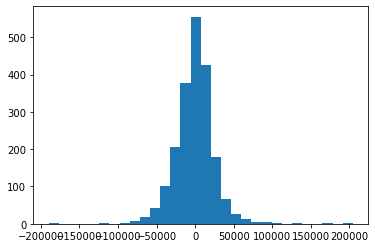

In [239]:
# We plot our residuals in a hsitogram
plt.hist(residuals, bins = 30);

We see that the residuals cluster around 0 which is a good sign for our model

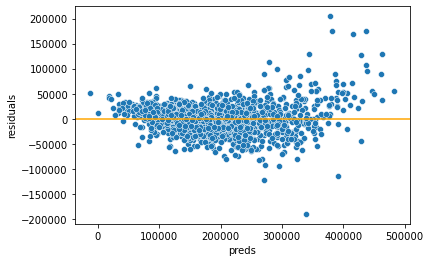

In [207]:
# We plot a scatter relating residuals to predictions
sns.scatterplot(x='preds', y='residuals', data=y_vs_pred)
plt.axhline(0, color = 'orange')

We see that the residuals suffer from slight heteroscedasticity towards the upper end after 400,000 saleprice. This is not a big issue as the bulk of house values lie between the rhe range of 100,000 to 300,000.

### 9.4 Model Summary

We now summarise the findings of our model.

We will use a ridge regression with specified variables standardised.

In [231]:
# These are our X and y variables 
X_new = df[['MS Zoning', 'Lot Area', 'Lot Shape',
       'House Style', 'Overall Qual', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Foundation', 'Bsmt Qual',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC',
       'Gr Liv Area', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Area', 'House Age',
       'Remod Age', 'Decks', 'Baths', 'Neighborhood_BrkSide',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert',
        'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker']]
y = df['SalePrice']

In [232]:
# These are the 2 groups of variables that have to be scaled
# Continuous variables
scale_needed_new = ['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
                 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'House Age',
                 'Remod Age', 'Decks' ]

# Categorical variables
no_scale_new = [ 'MS Zoning', 'Lot Shape',
                'House Style', 'Overall Qual',
                'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                'Exter Qual', 'Foundation', 'Bsmt Qual', 'Bsmt Fin Type 1',
                'Heating QC', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
                'Garage Type', 'Garage Finish', 'Baths' ,
          'Neighborhood_BrkSide',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
        'Neighborhood_Gilbert',
        'Neighborhood_Mitchel',  'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr',  'Neighborhood_Veenker']

In [233]:
# We look at the coefficients of our variables
for i, name in enumerate(X_new):
    print(name, ridge.coef_[i])

MS Zoning 3764.4486263341023
Lot Area 6273.03654295454
Lot Shape 387.7704902374836
House Style -3418.3271843676634
Overall Qual 11024.816982802784
Exterior 1st 5742.035322382599
Exterior 2nd -4989.305474065524
Mas Vnr Type -4142.91138158312
Mas Vnr Area 7093.373085445558
Exter Qual 11504.554542753855
Foundation 1361.8361477765372
Bsmt Qual -2050.098433654086
BsmtFin Type 1 -612.1623027993488
BsmtFin SF 1 11800.232577670242
Total Bsmt SF 7814.661413726369
Heating QC 1956.0289637706153
Gr Liv Area 22719.27626340906
Kitchen Qual 9858.53721415443
Fireplaces 3341.9043813093526
Fireplace Qu 650.8763381333307
Garage Type -814.758208771195
Garage Finish 1890.484163061198
Garage Area 5565.865820764039
House Age -5267.795830347233
Remod Age -3421.619267259177
Decks 2754.438393962792
Baths -563.0136413323615
Neighborhood_BrkSide 11041.475735944148
Neighborhood_CollgCr -4681.507691635289
Neighborhood_Crawfor 18563.66079748966
Neighborhood_Gilbert -3753.058325249463
Neighborhood_Mitchel 54511.90540

In [247]:
results = ridge.coef_

In [249]:
final = pd.DataFrame()

In [251]:
final['Variables'] = ['MS Zoning', 'Lot Area', 'Lot Shape',
       'House Style', 'Overall Qual', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Foundation', 'Bsmt Qual',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC',
       'Gr Liv Area', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Area', 'House Age',
       'Remod Age', 'Decks', 'Baths', 'Neighborhood_BrkSide',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert',
        'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker']

In [253]:
final

,Variables,Coef
0,MS Zoning,3494.014314
1,Lot Area,6301.486089
2,Lot Shape,267.872306
3,House Style,-3569.375556
4,Overall Qual,11090.268480
5,Exterior 1st,6097.654631
6,Exterior 2nd,-5559.735998
7,Mas Vnr Type,-4161.474781
8,Mas Vnr Area,7093.274734
9,Exter Qual,11652.203904


In [254]:
final.sort_values(by = 'Coef', ascending = False)

,Variables,Coef
39,Neighborhood_StoneBr,43368.555546
34,Neighborhood_NridgHt,27271.587655
16,Gr Liv Area,22746.082235
29,Neighborhood_Crawfor,18457.100056
33,Neighborhood_NoRidge,16388.453824
13,BsmtFin SF 1,11851.846853
9,Exter Qual,11652.203904
4,Overall Qual,11090.268480
27,Neighborhood_BrkSide,10864.290452
17,Kitchen Qual,9885.802937


### 9.5 Conclusions and Findings

We circle back to the our original problem:

*Our goal will be to find out if we can use linear regression models to accurately predict house prices on a chosen set of variables. Thereafter, we explore the results and find out which model serves us best and what the results of the model mean for predicting housing prices. We will be using root mean squared error to evaluate our models and choose the best one.*

We have indeed produced a model that allows us to predict house prices. We have presented the results of that model above (variables, coefficients and also the plot of residuals). Here are some thoughts from the model:

#### Neighborhoods/ Location plays an important role

We see that the different dummies for neighborhoods have some of the highest and lowest (most negative) coefficients in the model. What this translates to is that depending on the location of the house, there can be a significant premium or discount to the house price. For example, based on our model, StoneBr fetches over 43,000 in premium whereas SayerW is at a discount of over 10,000. However, we do have to keep in mind that this might just be the case of certain eighborhoods having larger houses and hence fetching a higher price. This is something to keep in mind when anaysing the data.

#### Maintaining House Quality is important

External quality, Overall quality and Kitchen quality have some of the most positive coefficients as well. This goes to show that maintaining the quality of some facets of your house can greatly impact house prices.

#### Living Area (of course)

It comes with no surprise that living area is also one of the top predictors of housing prices and this should come as no surprise.

#### Age of the House

We can also see that the age of the house matters. House Age and Remod Age are some of the most negative variables in our model. The older the house/ longer the time it has been since remodelling, the lower the house price.

### Implications for Home owners/ buyers

Overall our model gives us much insight and the information we gathered can be particularly useful for home owners looking to sell or buyers. Home owners looking to sell should ensure that they are familiar with the premium or discount of their location and also that the quality of the house is decent. They might even want to consider remodelling the house slightly before sale to reduce the negative impact this variable has on price. They should also look to sell earlier than later as each year that the house ages, the price of the house will decrease.

For home buyers, it is also necessary to check the premium and discount based on location. An extensive check on the quality of the house should also be in order before committing to the purchase.



#### Drawbacks of the model

From our plot of residuals, we can see that as house prices increase over the 400,000 range, our model starts to show a higher degree of variance and poorer predictions (greater residuals). This might be the case as the functional form of the model might not be a linear equation that has the same gradient over different ranges. I believe it would be fair to say that housing prices do not increase in step with any set of variables (of the first degree). However, our model still works decently well within the mainstream range of housing prices.

#### Refining our model with results

Another interesting finding is that using the lasso model's coefficients to eliminate irrelevant variables can in turn increase the accuracy of our overall model. We have done so and used ridge thereafter as we will be able to fine tune the coefficients, resulting in ridge being our favored model.


### Future Steps

A step that we can possibly take in the future is to fit different models over different house price ranges or different house sizes. My hypothesis is that the models will have some significant difference bepedning on the size and price range of the houses. We should also look to collect more data points for houses in the higher range as we lack observations and this could have caused some inaccuracy in our model towards the higher end of the house price range.

## <a name="sec_10"></a>10 Prediction

In this section, we now perform prediction on our unseen dataset and submit it to Kaggle.

In [234]:
# We set up our train and test variables. Note that Grnhill neighborhood is not in the test data, so we remove is# We set up our train and test variables. Note that Grnhill neighborhood is not in the test data, so we remove it

X_train = X_new
X_test = df_test[['MS Zoning', 'Lot Area', 'Lot Shape',
       'House Style', 'Overall Qual', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Foundation', 'Bsmt Qual',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC',
       'Gr Liv Area', 'Kitchen Qual', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Area', 'House Age',
       'Remod Age', 'Decks', 'Baths', 'Neighborhood_BrkSide',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert',
        'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker']]

y_train = df['SalePrice']

In [236]:
# We then scale our data
X_train_scaled = X_train
X_train_scaled[scale_needed_new] = ss.fit_transform(X_train_scaled[scale_needed_new])

X_test_scaled = X_test
X_test_scaled[scale_needed_new] = ss.transform(X_test_scaled[scale_needed_new])

In [237]:
# We then use ridge cv to find optimal alpha
ridgecv = RidgeCV(alphas = np.logspace(.1,100,100))
ridgecv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.25892541e+000, 1.28555573e+001, 1.31274937e+002, 1.34051824e+003,
       1.36887451e+004, 1.39783061e+005, 1.42739922e+006, 1.45759330e+007,
       1.48842609e+008, 1.51991108e+009, 1.55206209e+010, 1.58489319e+011,
       1.61841878e+012, 1.65265354e+013, 1.68761248e+014, 1.72331091e+015,
       1.75976447e+016, 1.79698915e+017, 1.83500125e+018, 1.87381742e+019,
       1.913454...
       6.17887047e+076, 6.30957344e+077, 6.44304121e+078, 6.57933225e+079,
       6.71850628e+080, 6.86062429e+081, 7.00574855e+082, 7.15394265e+083,
       7.30527154e+084, 7.45980152e+085, 7.61760031e+086, 7.77873705e+087,
       7.94328235e+088, 8.11130831e+089, 8.28288856e+090, 8.45809828e+091,
       8.63701425e+092, 8.81971488e+093, 9.00628020e+094, 9.19679199e+095,
       9.39133370e+096, 9.58999061e+097, 9.79284974e+098, 1.00000000e+100]))

In [238]:
ridgecv.alpha_

1.2589254117941673

In [239]:
# We then use ridge to predict y values
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=1.2589254117941673)

In [240]:
# We then predict our y
y = ridge.predict(X_test_scaled)

In [241]:
# We check the length of y
len(y)

879

In [242]:
# We create a new dataframe to hold these results
column_names = ['Id', 'SalePrice']
sub = pd.DataFrame(columns = column_names)

In [243]:
sub ['Id'] = df_test['Id']

In [244]:
sub['SalePrice'] = y

In [245]:
sub

,Id,SalePrice
0,2658,136336.888452
1,2718,186683.122936
2,2414,207444.970809
3,1989,111972.125921
4,625,174883.017996
...,...,...
874,1662,182539.016458
875,1234,234535.187338
876,1373,129930.082095
877,1672,109934.003490


In [246]:
# Export our findings
sub.to_csv('C:/Users/gregw/Desktop/General Assembly/dsi-roughwork/materials/project_2/datasets/submission4.csv', index = False)

Our submission yields the following scores:

Private: 31651.70434

Public: 29468.69403

